## Calculate AOU

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import xarray as xr
import os
import cftime
import gsw

In [2]:
# I/O setup
dir_in = '/Users/nd20983/Documents/data/'
data_list = ['xpvha','xpvhb','xpvhc','xpvhr','xpvhw',]
datanb_list = ['xqfqa','xqfqb','xqfqc','xqfqr','xqfqw']
dscb_list = ['GET_CTR','Sco_CTR','Rob_CTR','GET_RC','GET_LC']
dscbnb_list = ['GET_NB','Sco_NB','Rob_NB','RC_NB','LC_NB']
file_tail = 'o.pfclann.nc'
dir_out = os.path.abspath(os.path.join(
    os.getcwd(), '..','..','Simulations','data','OBM','figures'))
os.makedirs(dir_out, exist_ok=True)
# dir_outpath = os.path.join(dir_out, f"aour_map_{i}.png")

# read in files
ds_list = []
dsnb_list = []
for data in data_list:
    filename = os.path.join(dir_in, data + file_tail)
    # non-standard time units
    ds = xr.open_dataset(filename, decode_times=False)
    # manually convert time to cftime
    ds['t'].attrs['units'] = 'days since 2850-12-01 00:00:00'
    ds = xr.decode_cf(ds)
    ds_list.append(ds)

for data in datanb_list:
    filename = os.path.join(dir_in, data + file_tail)
    # non-standard time units
    ds = xr.open_dataset(filename, decode_times=False)
    # manually convert time to cftime
    ds['t'].attrs['units'] = 'days since 2850-12-01 00:00:00'
    ds = xr.decode_cf(ds)
    dsnb_list.append(ds)


# loop over ds_list
for i, ds in enumerate(ds_list):
    # get essential variables
    temp = ds['temp_mm_dpth']
    salt = ds['salinity_mm_dpth']
    oxygen = ds['O2_mm_dpth']
    # get coordinates
    lat = ds['latitude']
    lon = ds['longitude']
    depth = ds['depth_2']

    # compute oxygen solubility (in umol/kg)
    O2_sat = gsw.O2sol_SP_pt(salt.values, temp.values)

    # compute AOU
    aou = xr.DataArray(O2_sat - oxygen.values, coords=oxygen.coords, dims=oxygen.dims)
    aou.name = 'AOU'
    aou.attrs["units"] = "µmol/kg"
    aou.attrs["long_name"] = "Apparent Oxygen Utilization"

    # add to dataset
    ds['AOU'] = aou

# loop over dsnb_list
for i, ds in enumerate(dsnb_list):
    # get essential variables
    temp = ds['temp_mm_dpth']
    salt = ds['salinity_mm_dpth']
    if i in (0,1):
        oxygen = ds['O2_mm_dpth']
    else:
        oxygen = ds['otracer13_mm_dpth']
    # get coordinates
    lat = ds['latitude']
    lon = ds['longitude']
    depth = ds['depth_2']

    # compute oxygen solubility (in umol/kg)
    O2_sat = gsw.O2sol_SP_pt(salt.values, temp.values)

    # compute AOU
    aou = xr.DataArray(O2_sat - oxygen.values, coords=oxygen.coords, dims=oxygen.dims)
    aou.name = 'AOU'
    aou.attrs["units"] = "µmol/kg"
    aou.attrs["long_name"] = "Apparent Oxygen Utilization"

    # add to dataset
    ds['AOU'] = aou


/var/folders/sq/wfj9lzcx6437thzlt85cgjwr0000gp/T/ipykernel_1569/1761502222.py:22: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xr.decode_cf(ds)
/var/folders/sq/wfj9lzcx6437thzlt85cgjwr0000gp/T/ipykernel_1569/1761502222.py:22: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xr.decode_cf(ds)
/var/folders/sq/wfj9lzcx6437thzlt85cgjwr0000gp/T/ipykernel_1569/1761502222.py:22: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning

In [88]:
print(ds_list[0])
print(dsnb_list[0])

<xarray.Dataset> Size: 5MB
Dimensions:                     (longitude: 96, latitude: 73, depth: 10, t: 1,
                                 unspecified: 1, depth_1: 1, depth_2: 10,
                                 longitude_1: 96, latitude_1: 72)
Coordinates:
  * longitude                   (longitude) float32 384B 0.0 3.75 ... 356.2
  * latitude                    (latitude) float32 292B -90.0 -87.5 ... 90.0
  * depth                       (depth) float32 40B 10.0 20.0 ... 242.6 359.4
  * t                           (t) object 8B 6751-01-17 00:00:00
  * unspecified                 (unspecified) float32 4B -1.0
  * depth_1                     (depth_1) float32 4B 5.0
  * depth_2                     (depth_2) float32 40B 5.0 15.0 ... 203.7 301.0
  * longitude_1                 (longitude_1) float32 384B 1.875 5.625 ... 358.1
  * latitude_1                  (latitude_1) float32 288B -88.75 ... 88.75
Data variables: (12/41)
    W_mm_dpth                   (t, depth, latitude, longitude) fl

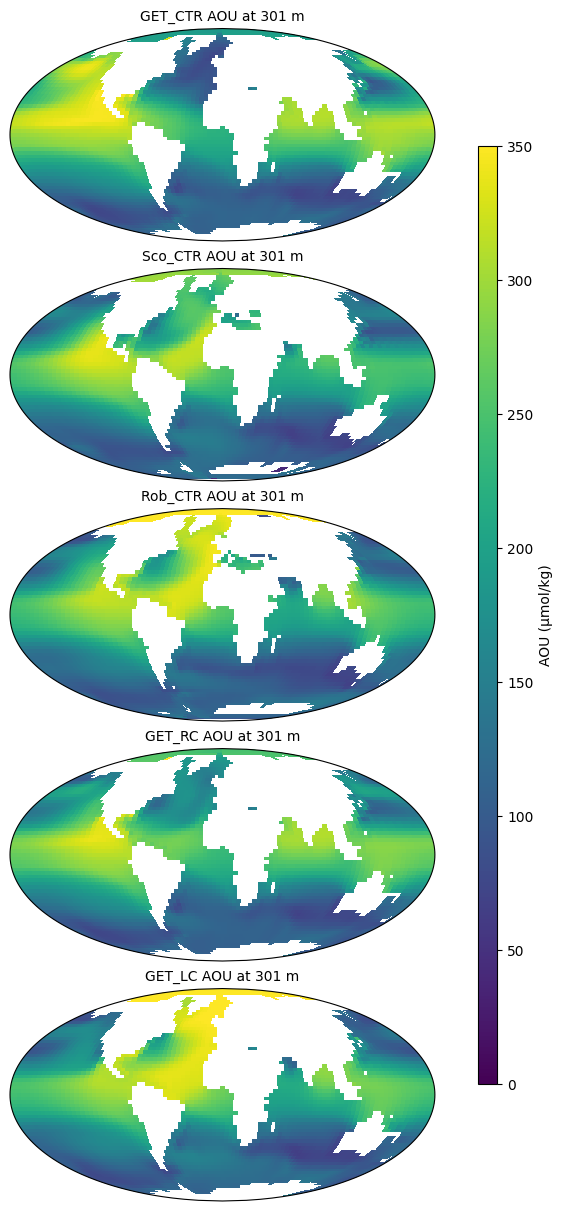

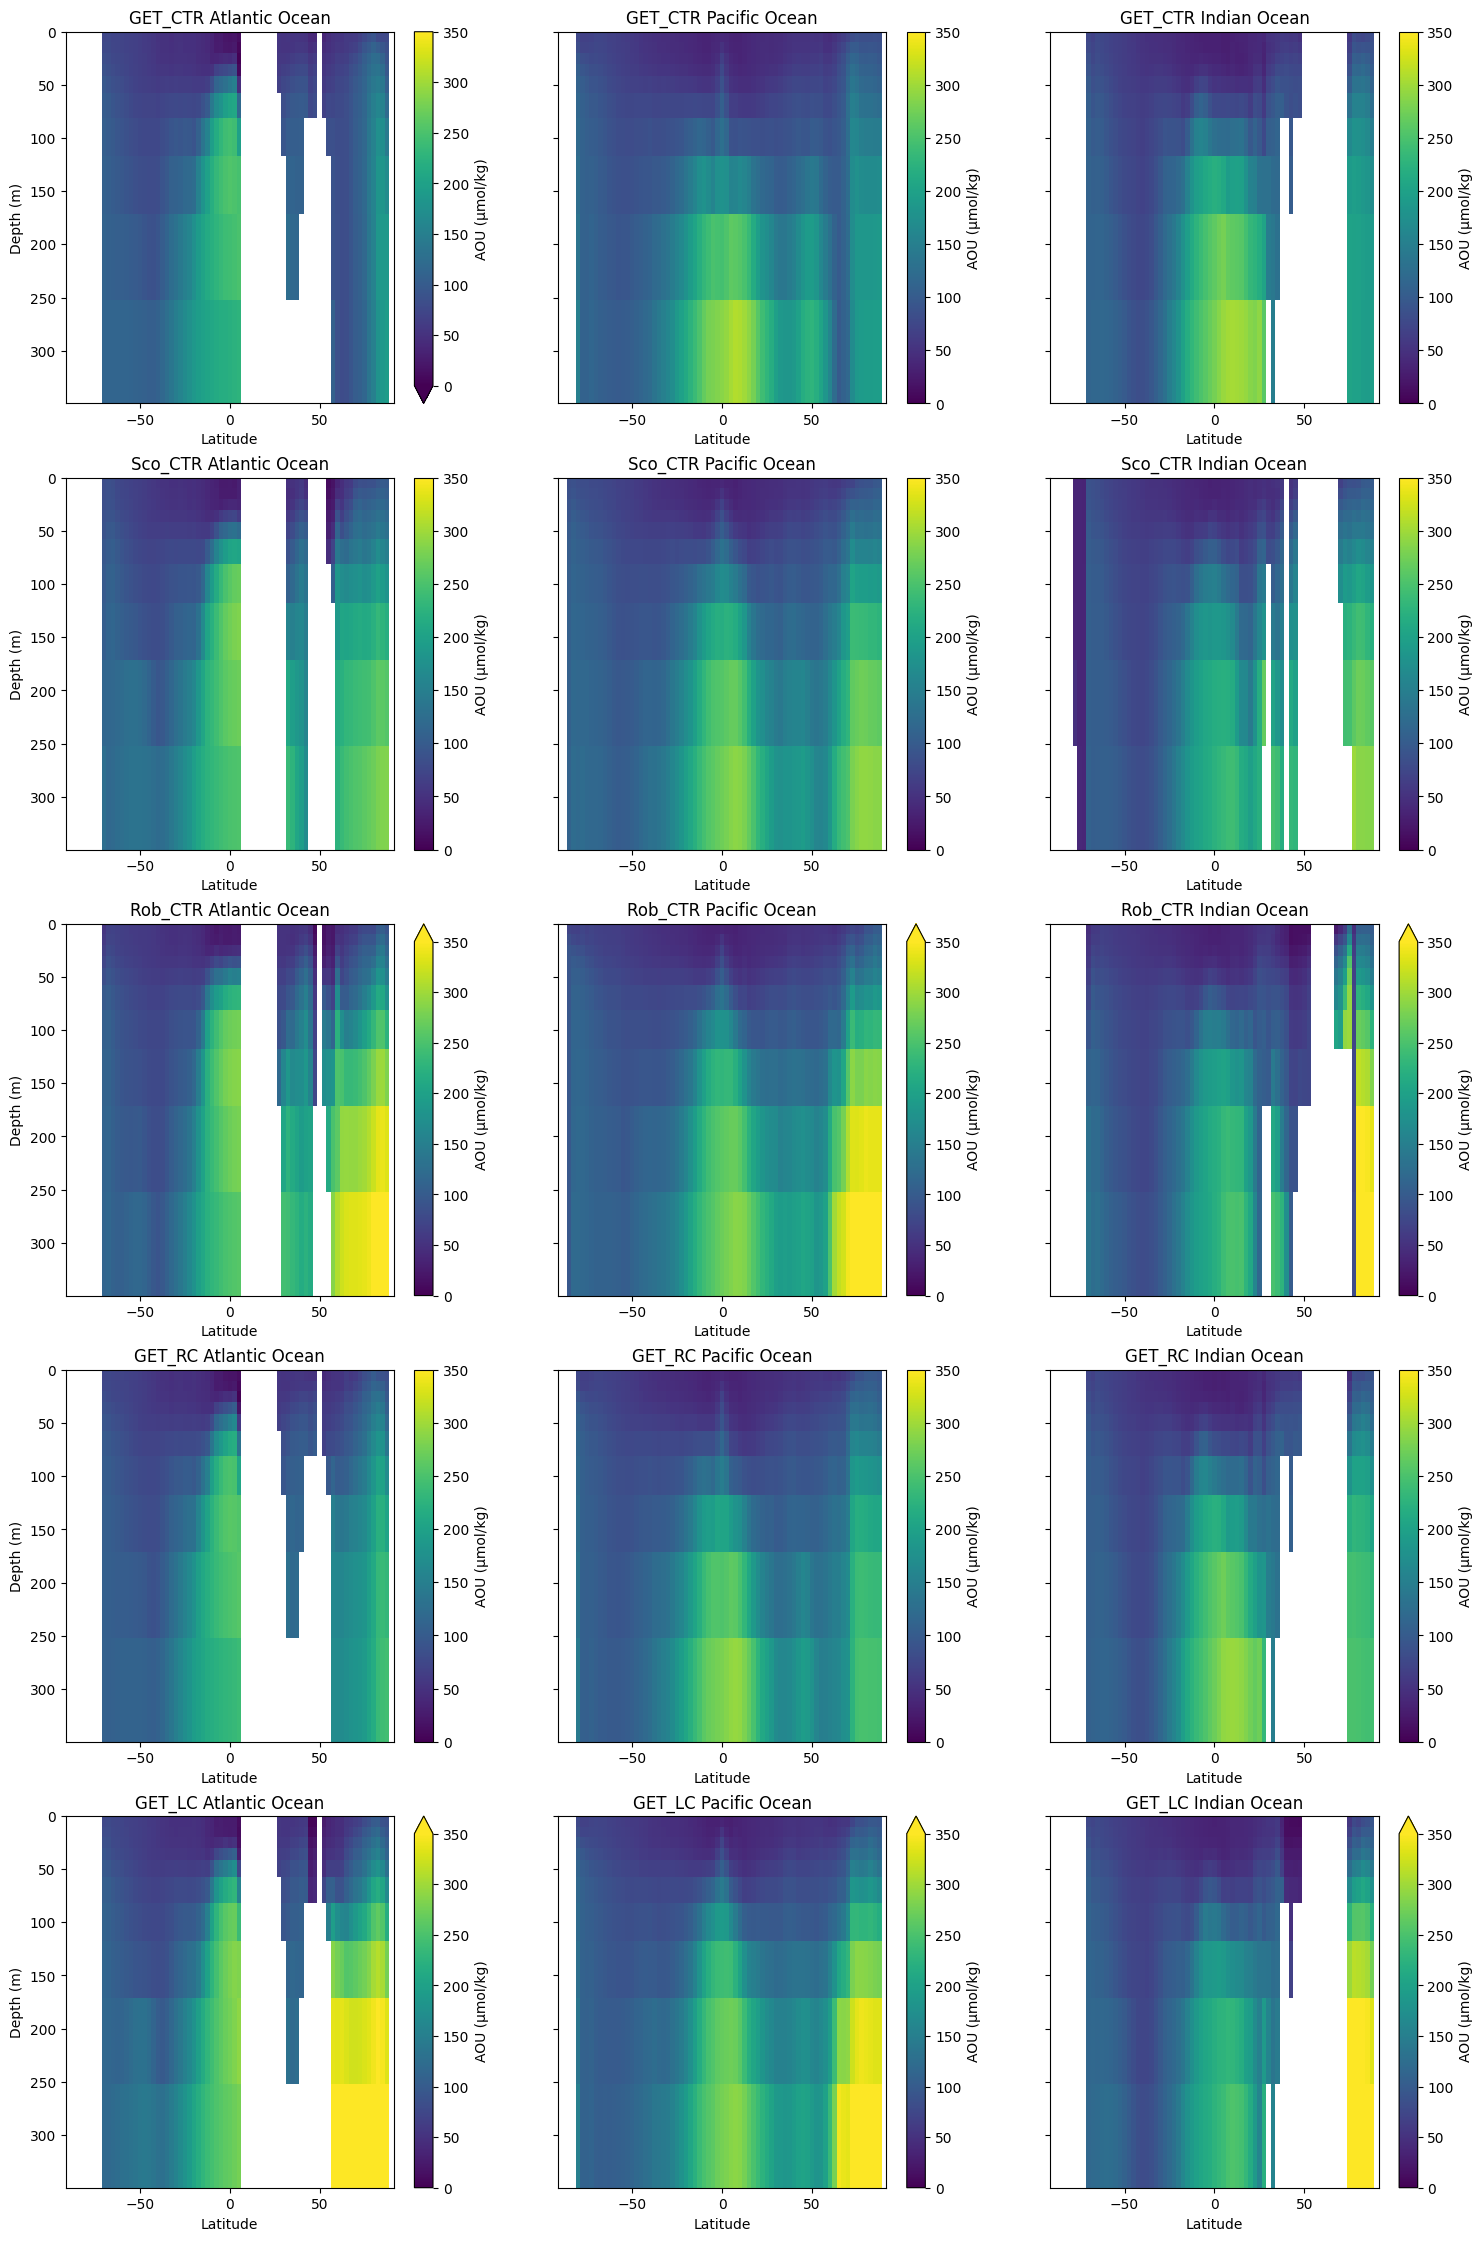

In [163]:
# ==============================================
# This is a copy of the following cell, to test.
# Test failed, as the NB expts are identical to the original set.
# ==============================================

# figure for global patterns at 301m
rows, cols =5, 1
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(10,12), constrained_layout=True,
                        subplot_kw={'projection': ccrs.Mollweide()})

# figure for basin levels
fig1, axs1 = plt.subplots(5, 3, figsize=(18, 28), sharey=True)

# loop over ds_list
bounds = list(range(0, 10, 1))
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256)
for d in range(5):
    aou = ds_list[d]['AOU']
    aounb = dsnb_list[d]['AOU']
    # test ==================================
    salt = ds_list[d]['salinity_mm_dpth']
    saltnb = dsnb_list[d]['salinity_mm_dpth']
    # =======================================
    ax = axs[d]
    # ax1 = axs[d, 1]
    im = ax.pcolormesh(lon, lat, aou.isel(t=0, depth_2=9), shading='auto', cmap='viridis',
                        vmin=0, vmax=350, transform=ccrs.PlateCarree())
    ax.set_title(f"{dscb_list[d]} AOU at {int(depth[9].values)} m", fontsize=10)
    # im1 = ax1.pcolormesh(lon, lat, aounb.isel(t=0, depth_2=9), shading='auto', cmap='viridis',
    #                     vmin=0, vmax=350, transform=ccrs.PlateCarree())
    # ax1.set_title(f"{dscbnb_list[d]} AOU at {int(depth[9].values)} m", fontsize=10)
    # im1 = ax1.pcolormesh(lon, lat, aounb.isel(t=0, depth_2=9)-aou.isel(t=0, depth_2=9), shading='auto', cmap='viridis',
                        #  norm=norm, transform=ccrs.PlateCarree())
    # ax1.set_title(f"{dscbnb_list[d]} AOU at {int(depth[9].values)} m", fontsize=10)
    
# plt.colorbar(im, label='AOU (µmol/kg)')
# fig.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical', label='AOU (µmol/kg)',
#                 shrink=0.8, aspect=30)
fig.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical', label='AOU (µmol/kg)',
             shrink=0.8, aspect=50,)
# fig.colorbar(im1, ax=axs.ravel().tolist(), orientation='vertical', label='AOU (µmol/kg)',
            #  shrink=0.8, aspect=50)
# fig.suptitle(dscb_list[i], fontsize=14)

# export figure
# dir_outpath = os.path.join(dir_out, f"AOU_depth_layers_{dscb_list[i]}.png")
# fig.savefig(dir_outpath, dpi=300,)

# plots for zonal means
# Ocean basin masks
basins = {
    "Atlantic": ((lon >= -100) & (lon <= 20)),
    "Pacific": ((lon >= 120) | (lon <= -70)),
    "Indian": ((lon >= 20) & (lon <= 120)),
}

# Zonal mean plots
for d in range(len(ds_list)):
    aou = ds_list[d]['AOU']
    for j, (name, mask) in enumerate(basins.items()):
        ax = axs1[d, j]
        aou_basin = aou.where(mask, drop=True)
        zonal_mean = aou_basin.mean(dim="longitude", skipna=True)

        im = zonal_mean.plot(ax=ax, y="depth_2", yincrease=False, cmap="viridis", 
                                vmin=0, vmax=350, cbar_kwargs={"label": "AOU (µmol/kg)"})
        ax.set_title(f"{dscb_list[d]} {name} Ocean")
        ax.set_xlabel("Latitude")
        # for first column only set up y label
        if j == 0:
            ax.set_ylabel("Depth (m)")
        else:
            ax.set_ylabel("")

    # # fig.colorbar(im, ax=axs.ravel().tolist(), label="AOU (µmol/kg)", orientation='vertical')

    # fig1.suptitle(f"Zonal Mean AOU by Ocean Basin in {dscb_list[i]}", fontsize=14)

    # export figure
    # dir_outpath1 = os.path.join(dir_out, f"AOU_zonal_mean_ocean_basins_{dscb_list[i]}.png")
    # fig1.savefig(dir_outpath1, dpi=300)

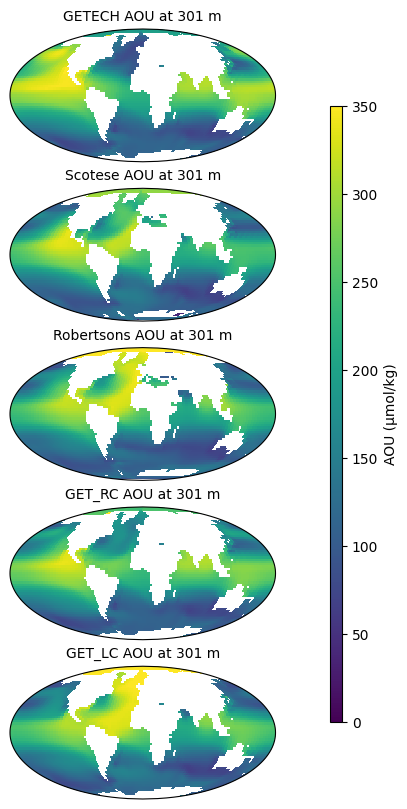

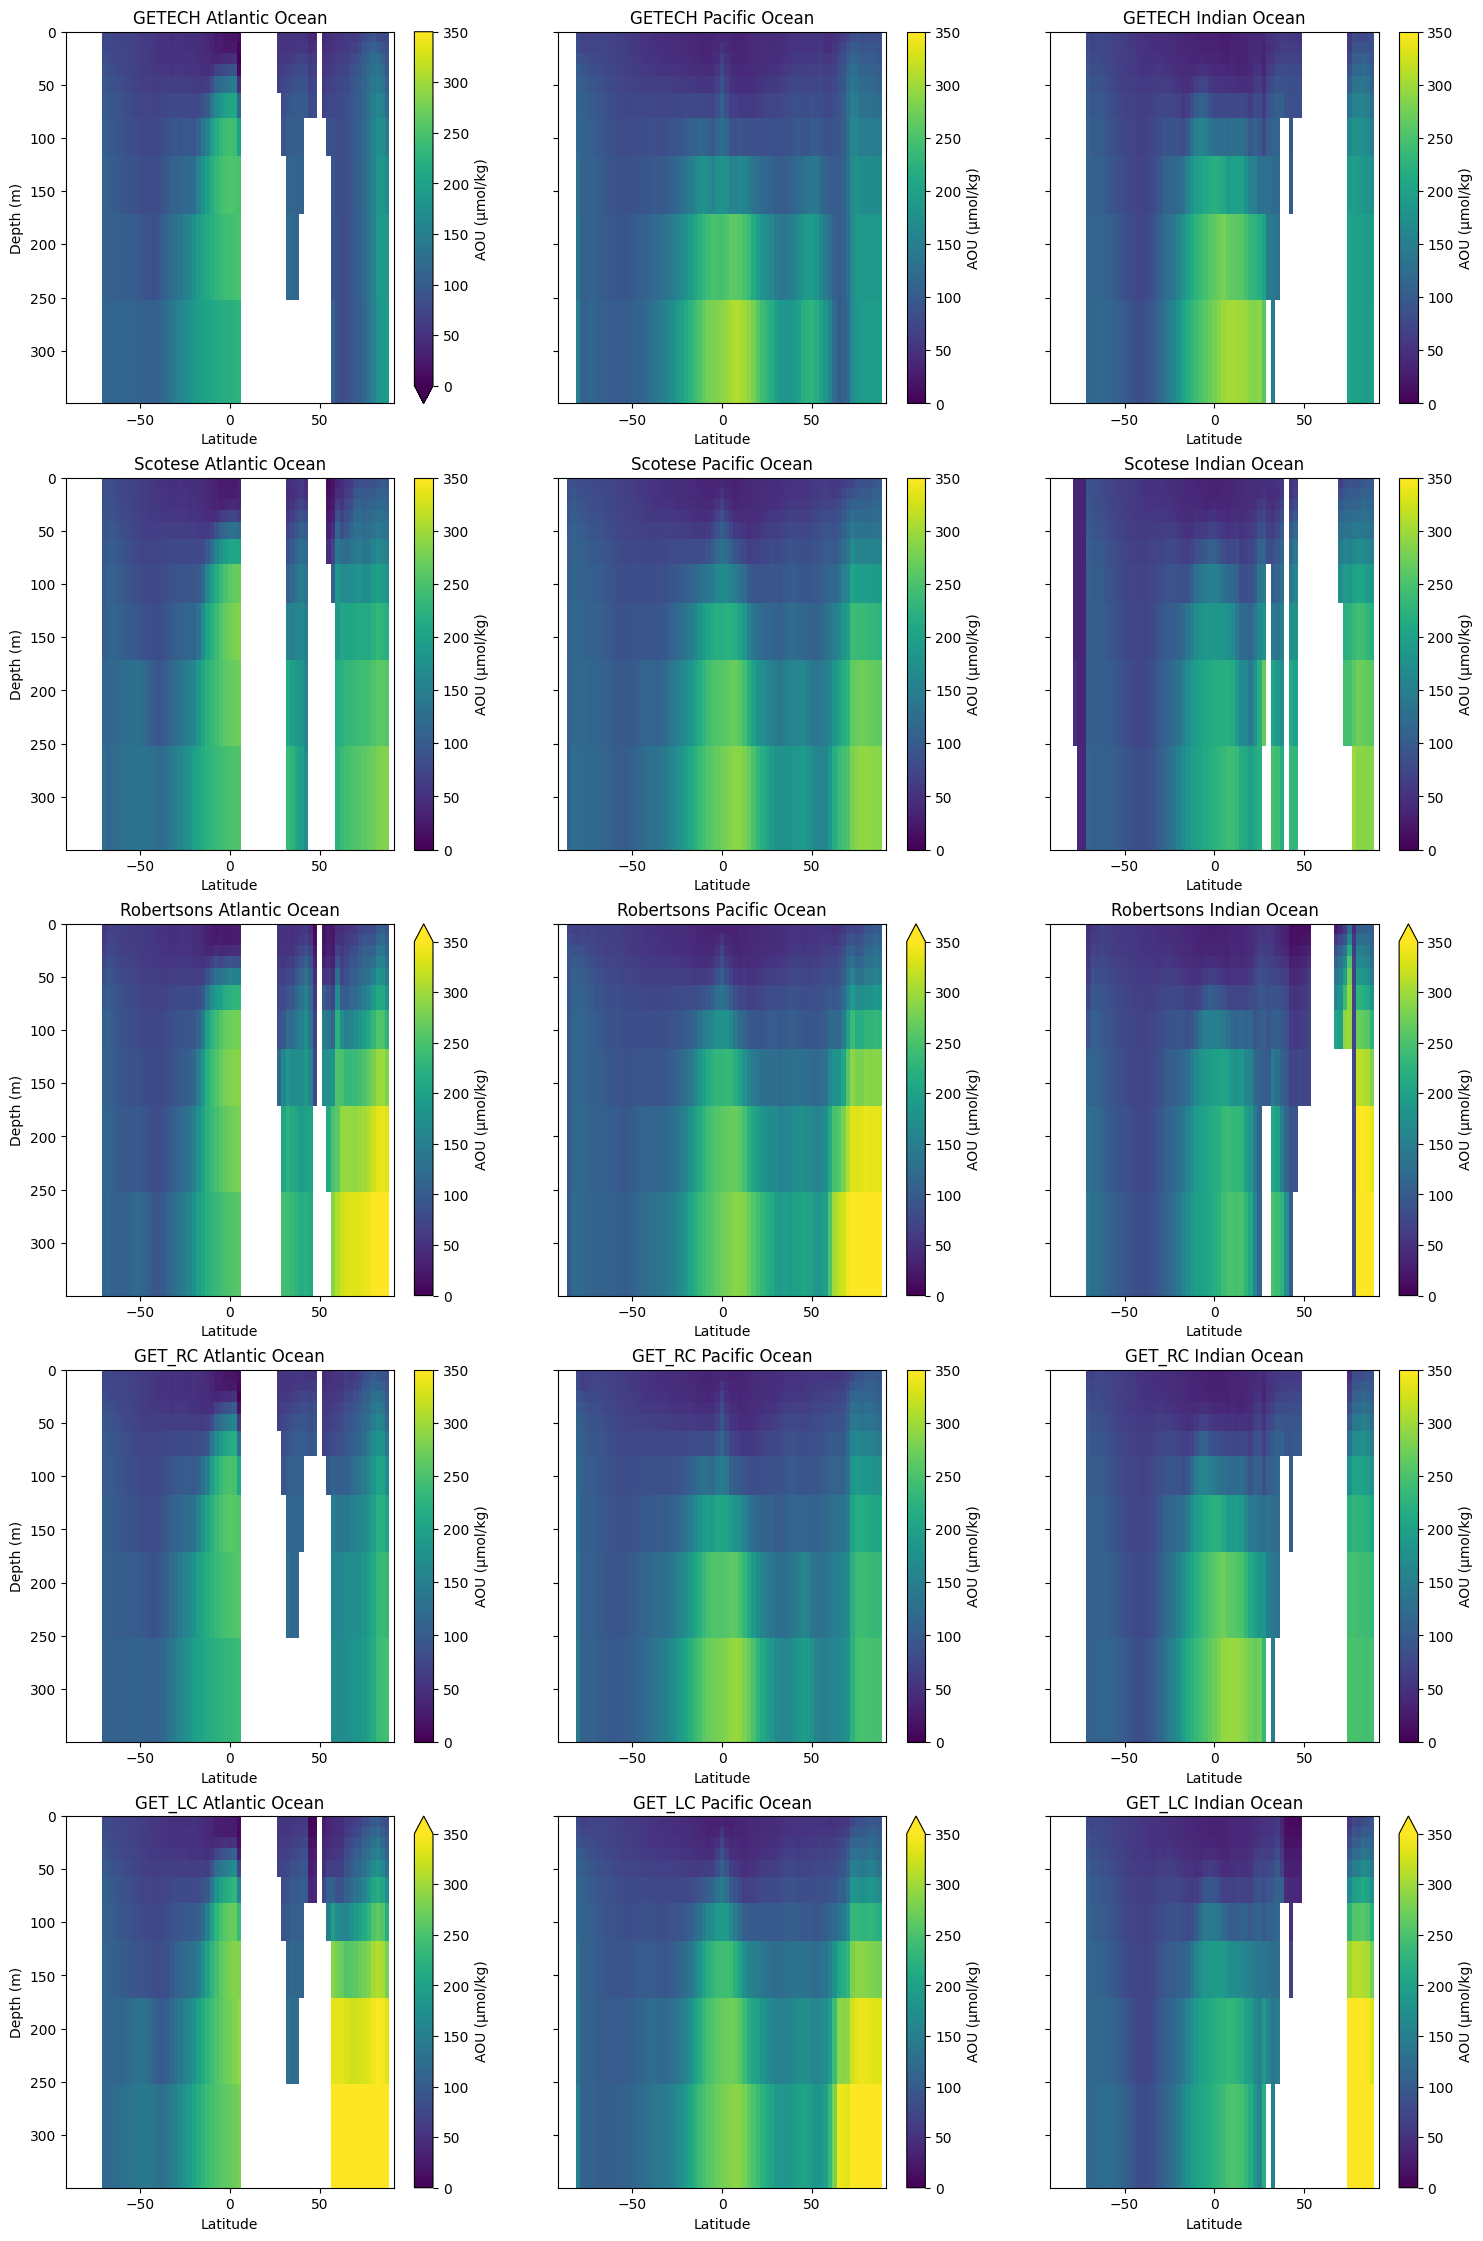

In [ ]:
# ==============================================
# This is a copy of the following cell, to test.
# Test okay, this is the updated plots.
# ==============================================

# figure for global patterns at 301m
rows, cols =5, 1
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(14,10), constrained_layout=False,
                        subplot_kw={'projection': ccrs.Mollweide()})

# figure for basin levels
fig1, axs1 = plt.subplots(5, 3, figsize=(18, 28), sharey=True)

# loop over ds_list
aou = ds['AOU']
for d, ax in zip(range(rows * cols), axs.ravel()):
    aou = ds_list[d]['AOU']
    im = ax.pcolormesh(lon, lat, aou.isel(t=0, depth_2=9), shading='auto', cmap='viridis',
                        vmin=0, vmax=350, transform=ccrs.PlateCarree())
    ax.set_title(f"{dscb_list[d]} AOU at {int(depth[9].values)} m", fontsize=10)
# plt.colorbar(im, label='AOU (µmol/kg)')
# fig.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical', label='AOU (µmol/kg)',
#                 shrink=0.8, aspect=30)
fig.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical', label='AOU (µmol/kg)',
             shrink=0.8, aspect=50)
# fig.suptitle(dscb_list[i], fontsize=14)

# export figure
# dir_outpath = os.path.join(dir_out, f"AOU_depth_layers_{dscb_list[i]}.png")
# fig.savefig(dir_outpath, dpi=300,)

# plots for zonal means
# Ocean basin masks
basins = {
    "Atlantic": ((lon >= -100) & (lon <= 20)),
    "Pacific": ((lon >= 120) | (lon <= -70)),
    "Indian": ((lon >= 20) & (lon <= 120)),
}

# Zonal mean plots
for d in range(rows * cols):
    aou = ds_list[d]['AOU']
    for j, (name, mask) in enumerate(basins.items()):
        ax = axs1[d, j]
        aou_basin = aou.where(mask, drop=True)
        zonal_mean = aou_basin.mean(dim="longitude", skipna=True)

        im = zonal_mean.plot(ax=ax, y="depth_2", yincrease=False, cmap="viridis", 
                                vmin=0, vmax=350, cbar_kwargs={"label": "AOU (µmol/kg)"})
        ax.set_title(f"{dscb_list[d]} {name} Ocean")
        ax.set_xlabel("Latitude")
        # for first column only set up y label
        if j == 0:
            ax.set_ylabel("Depth (m)")
        else:
            ax.set_ylabel("")

    # # fig.colorbar(im, ax=axs.ravel().tolist(), label="AOU (µmol/kg)", orientation='vertical')

    # fig1.suptitle(f"Zonal Mean AOU by Ocean Basin in {dscb_list[i]}", fontsize=14)

    # export figure
    # dir_outpath1 = os.path.join(dir_out, f"AOU_zonal_mean_ocean_basins_{dscb_list[i]}.png")
    # fig1.savefig(dir_outpath1, dpi=300)

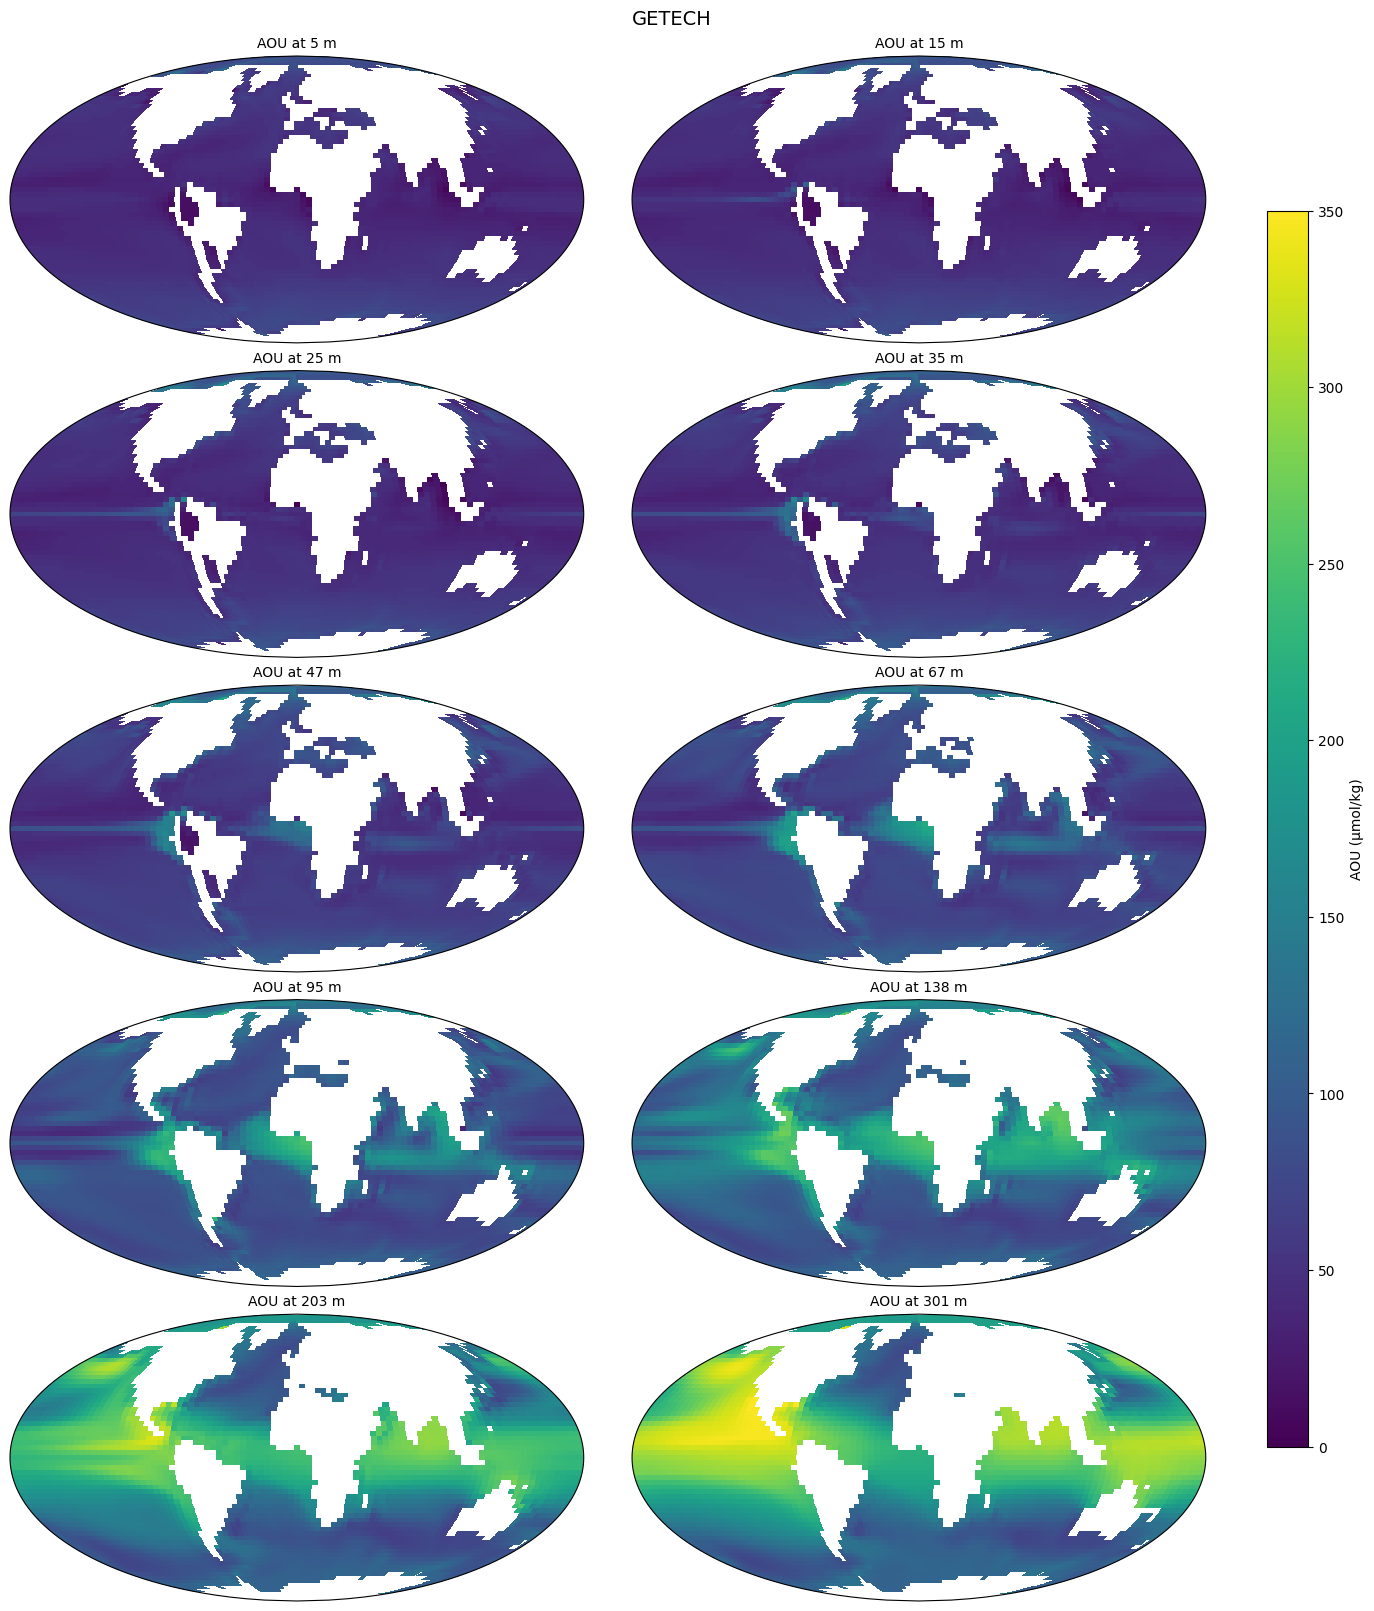

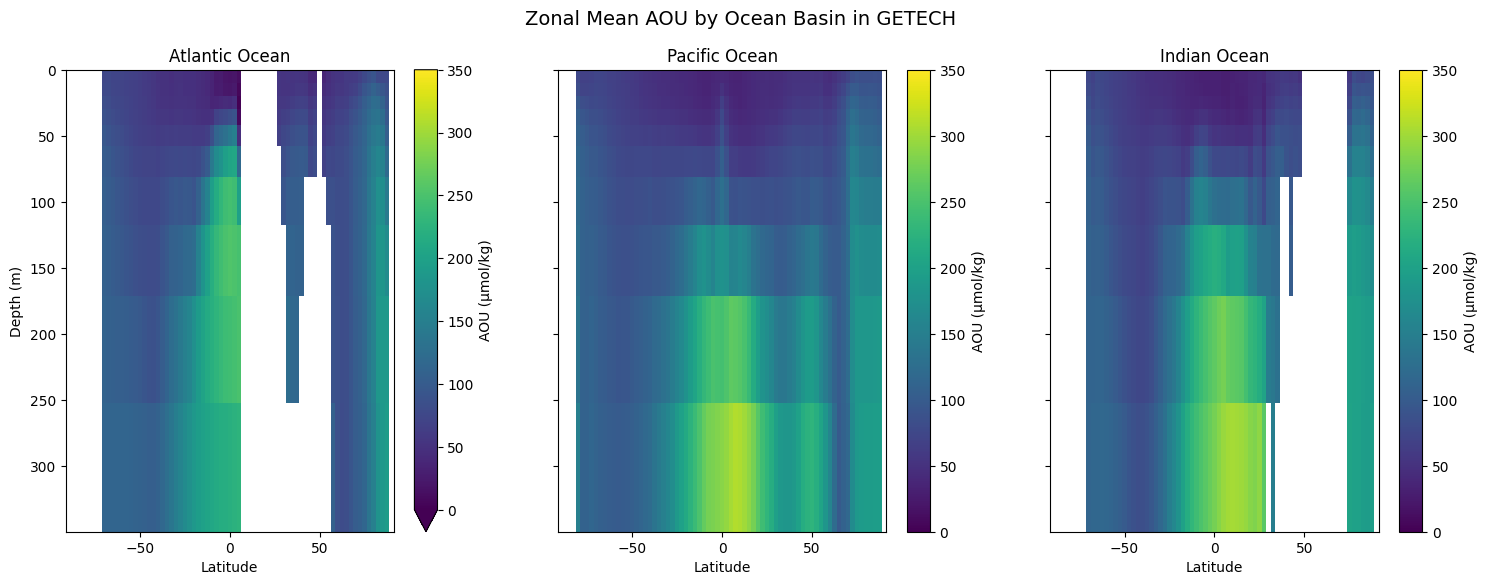

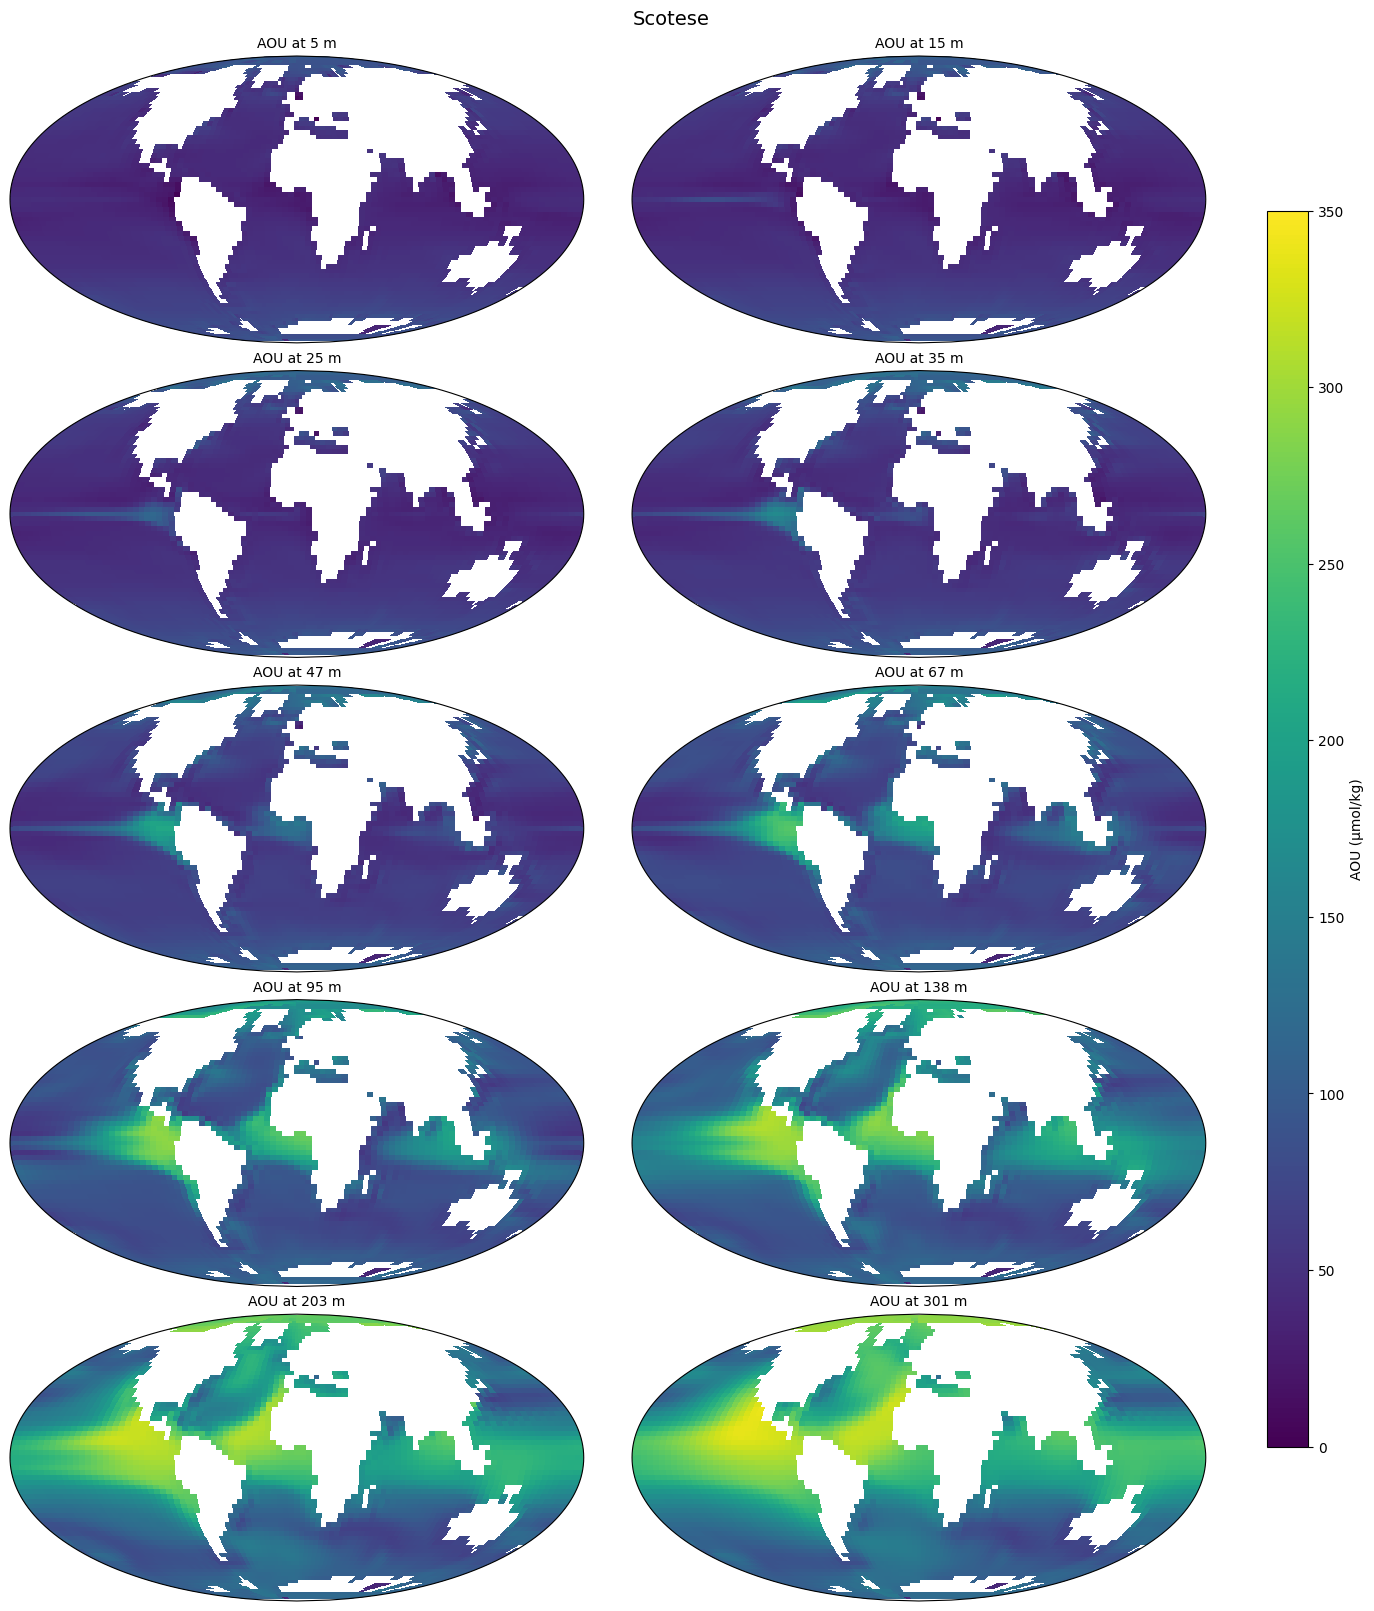

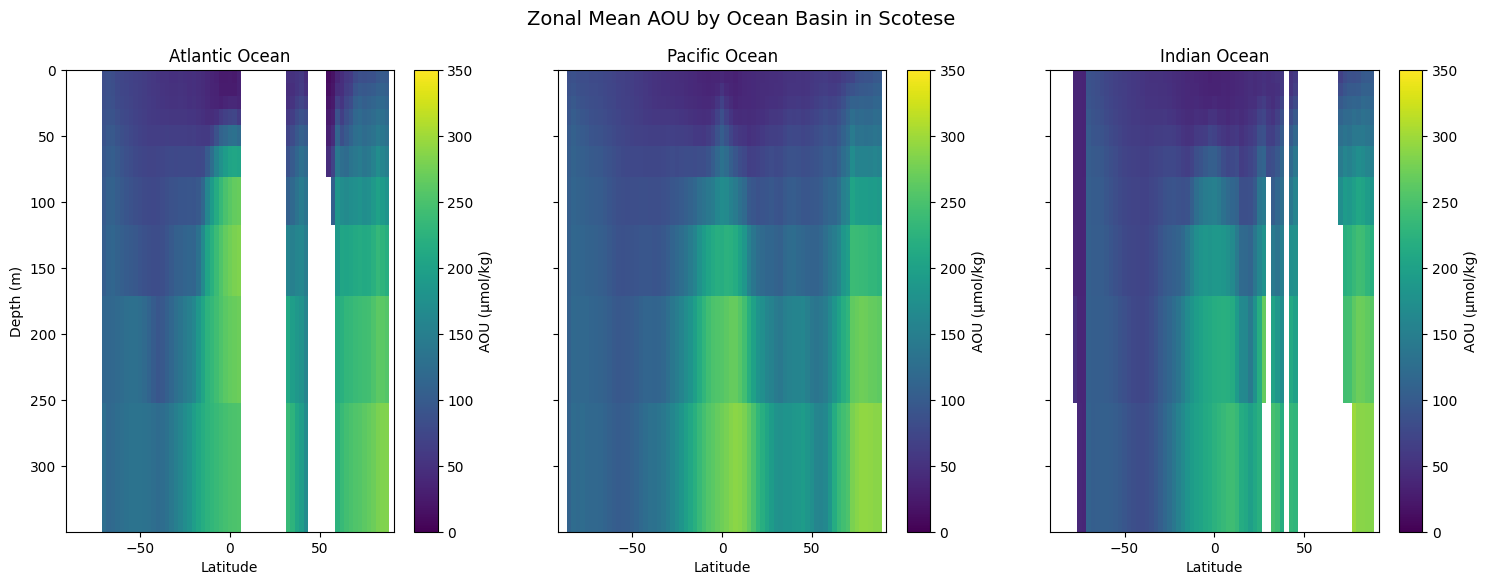

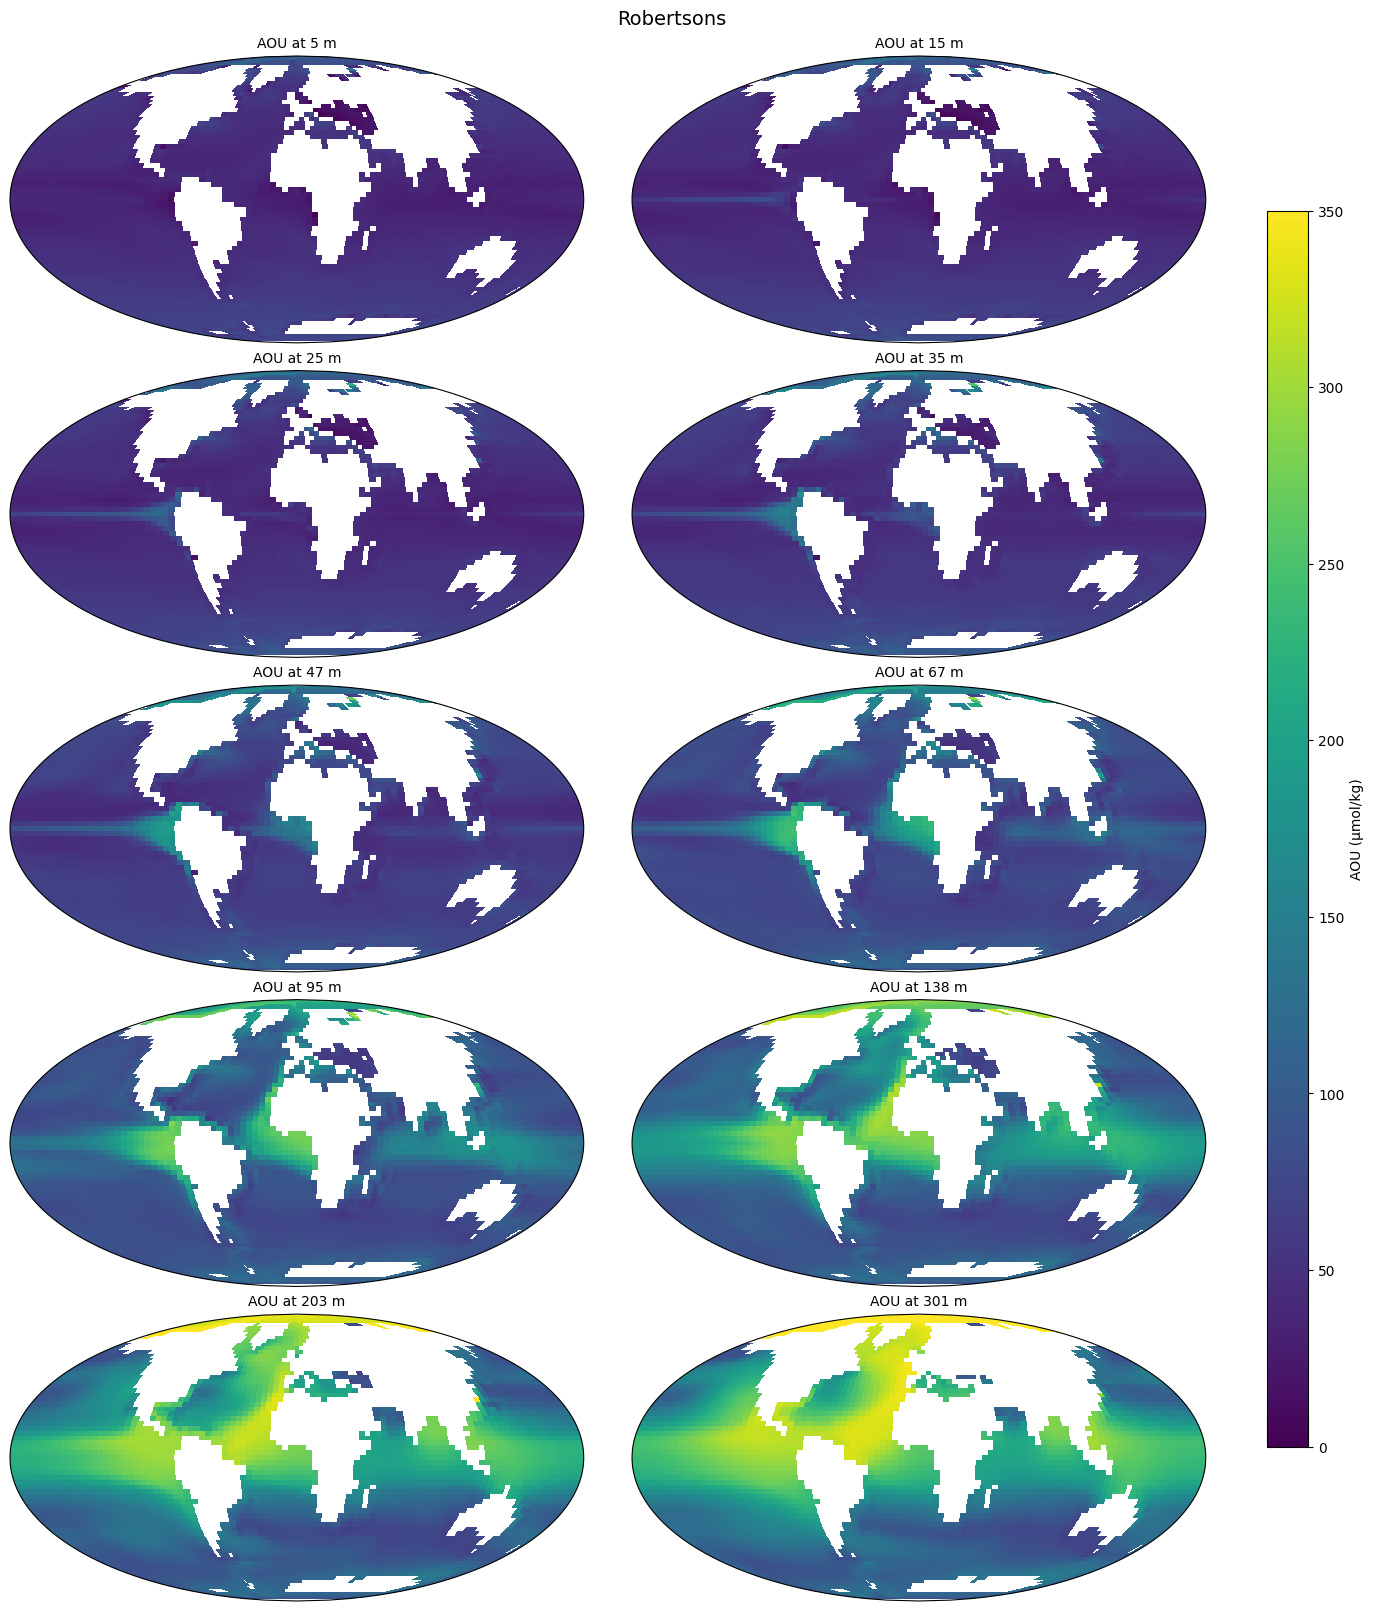

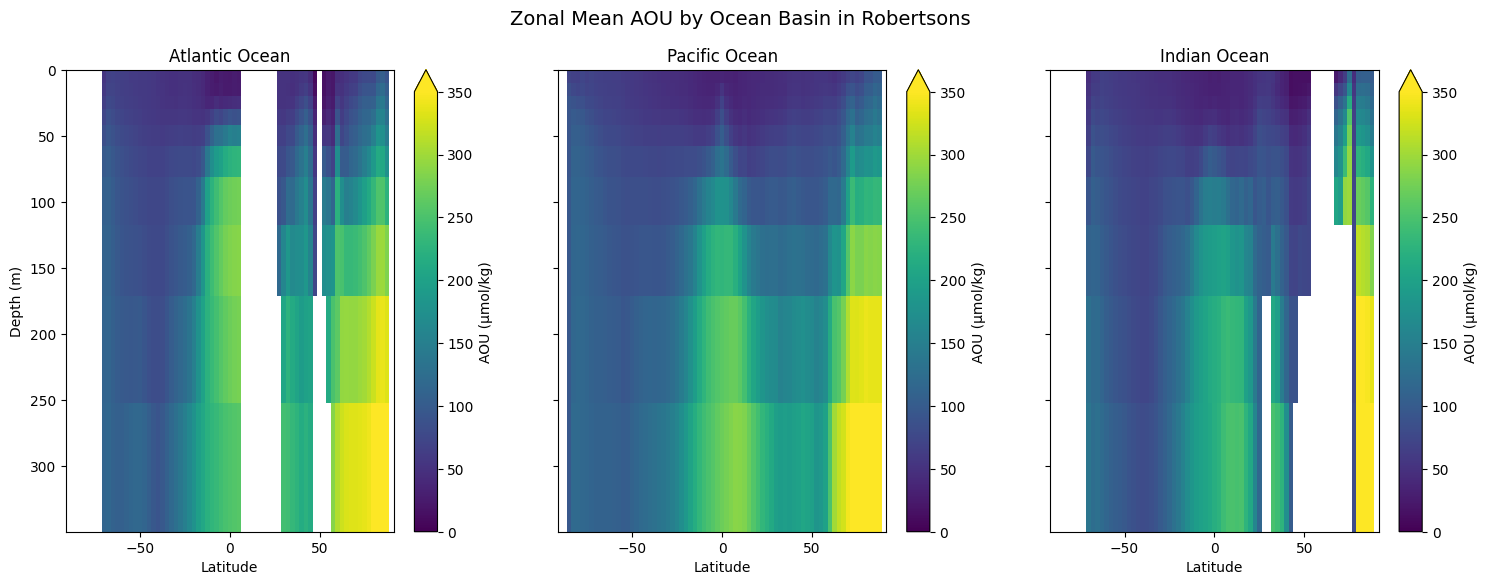

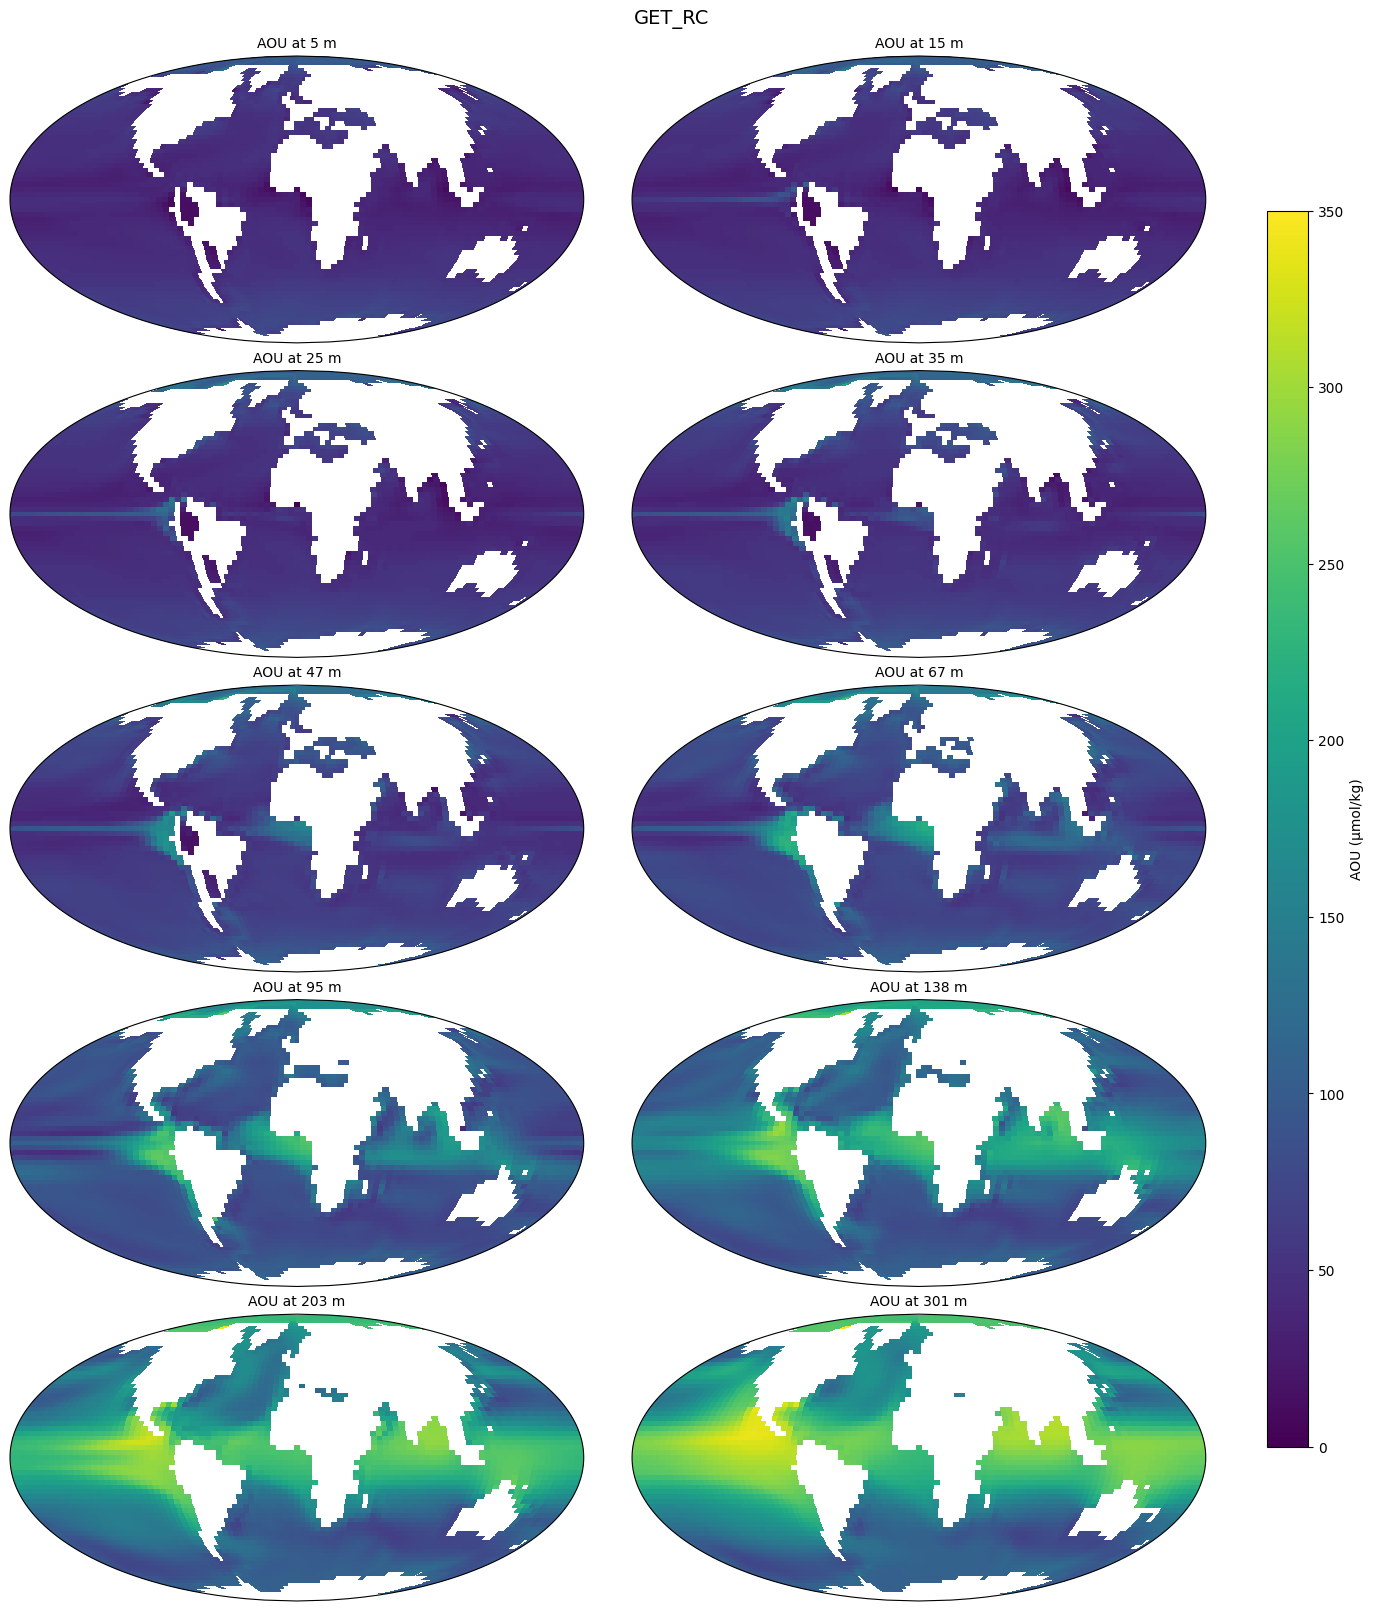

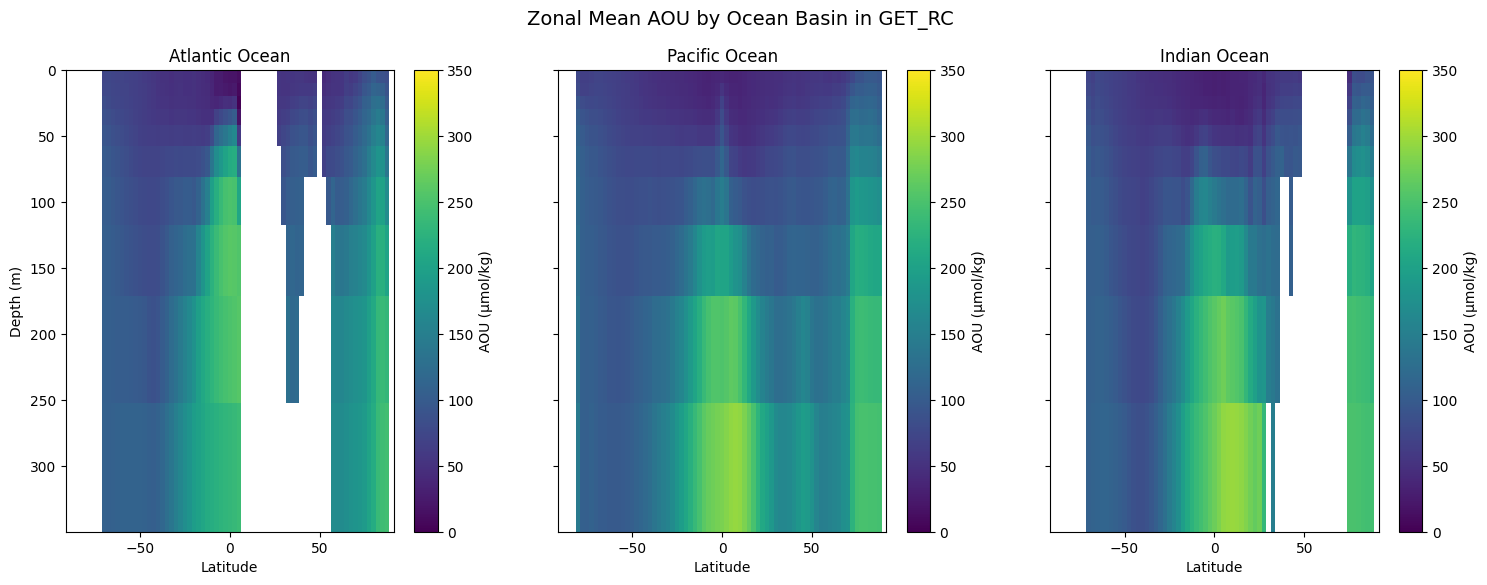

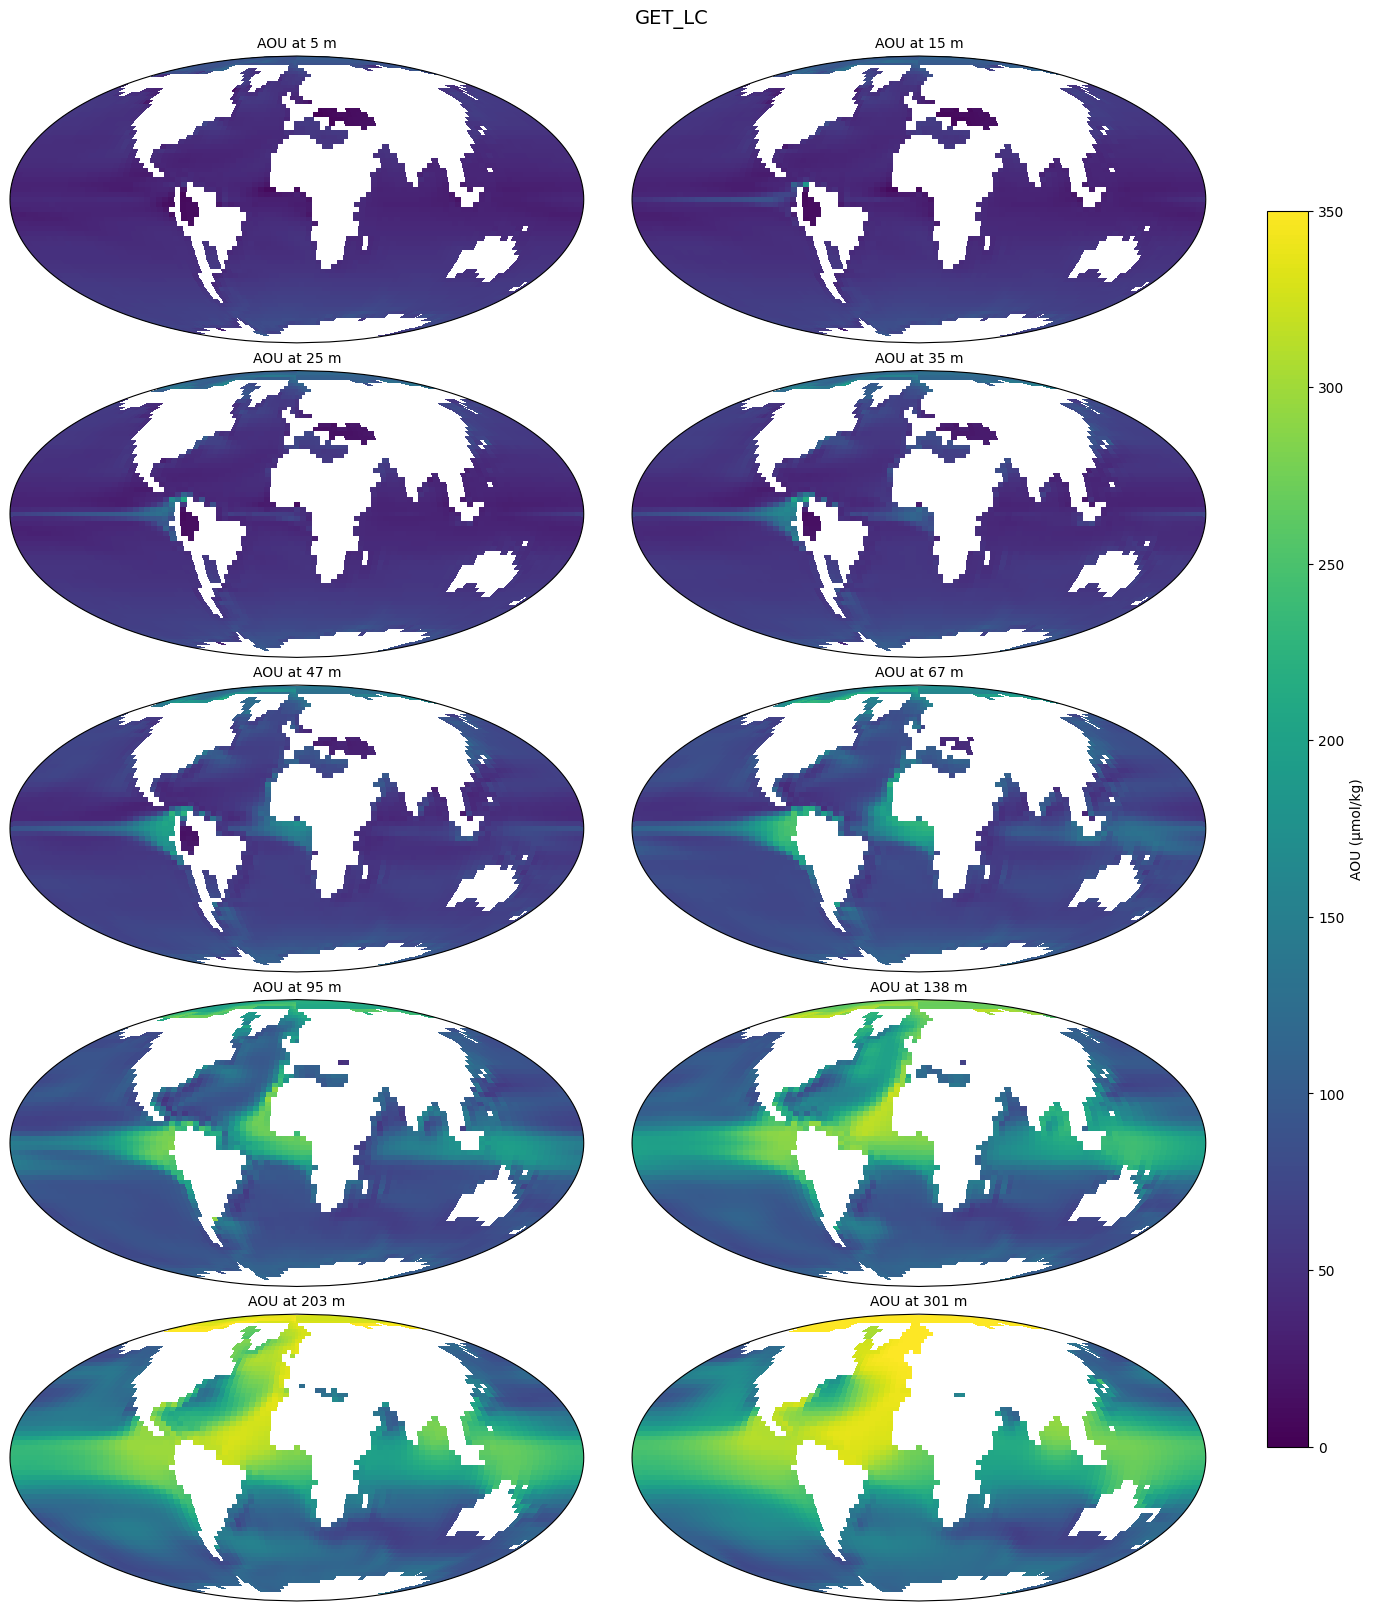

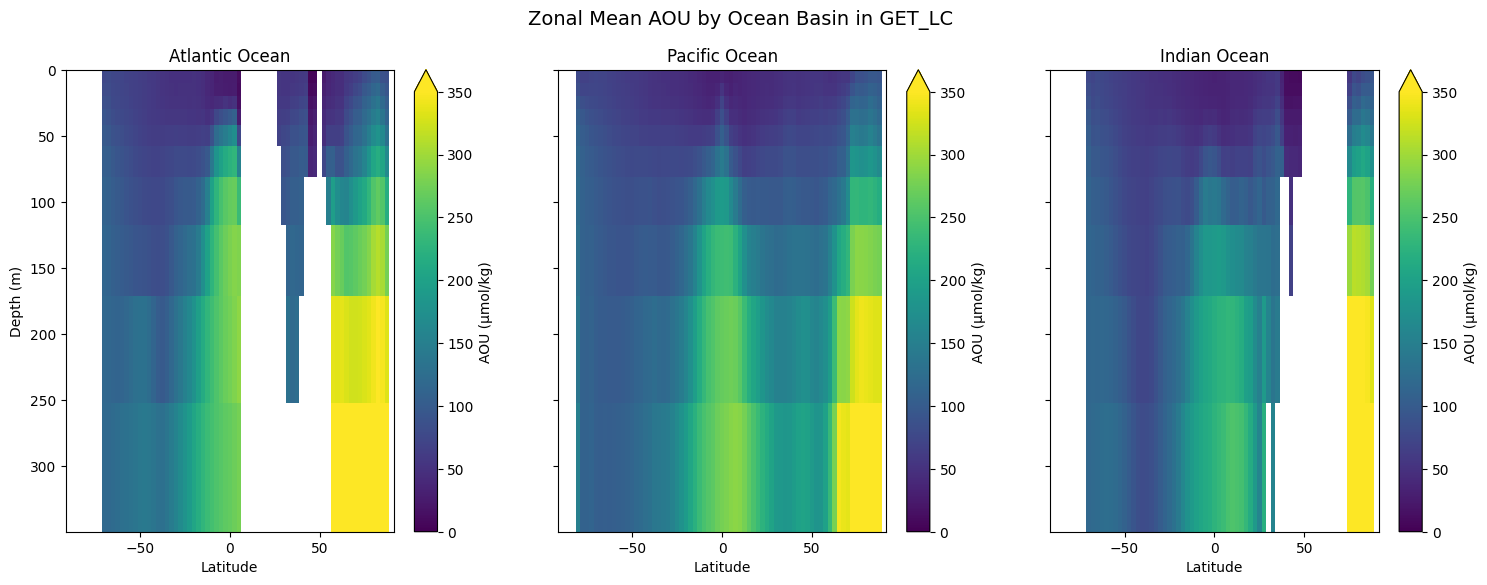

In [8]:
# loop over ds_list
for i, ds in enumerate(ds_list):
    aou = ds['AOU']
    # plots for vertical layers
    rows, cols =5, 2
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(14,16), constrained_layout=True,
                            subplot_kw={'projection': ccrs.Mollweide()})
    for d, ax in zip(range(rows * cols), axs.ravel()):
        im = ax.pcolormesh(lon, lat, aou.isel(t=0, depth_2=d), shading='auto', cmap='viridis',
                           vmin=0, vmax=350, transform=ccrs.PlateCarree())
        ax.set_title(f"AOU at {int(depth[d].values)} m", fontsize=10)
    # plt.colorbar(im, label='AOU (µmol/kg)')
    fig.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical', label='AOU (µmol/kg)',
                 shrink=0.8, aspect=30)
    fig.suptitle(dscb_list[i], fontsize=14)

    # export figure
    # dir_outpath = os.path.join(dir_out, f"AOU_depth_layers_{dscb_list[i]}.png")
    # fig.savefig(dir_outpath, dpi=300,)

    # plots for zonal means
    # Ocean basin masks
    basins = {
        "Atlantic": ((lon >= -100) & (lon <= 20)),
        "Pacific": ((lon >= 120) | (lon <= -70)),
        "Indian": ((lon >= 20) & (lon <= 120)),
    }

    fig1, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    # Zonal mean plots
    for j, (name, mask) in enumerate(basins.items()):
        ax = axs[j]
        aou_basin = aou.where(mask, drop=True)
        zonal_mean = aou_basin.mean(dim="longitude", skipna=True)

        im = zonal_mean.plot(ax=ax, y="depth_2", yincrease=False, cmap="viridis", 
                             vmin=0, vmax=350, cbar_kwargs={"label": "AOU (µmol/kg)"})
        ax.set_title(f"{name} Ocean")
        ax.set_xlabel("Latitude")
        # for first column only set up y label
        if j == 0:
            ax.set_ylabel("Depth (m)")
        else:
            ax.set_ylabel("")

    # fig.colorbar(im, ax=axs.ravel().tolist(), label="AOU (µmol/kg)", orientation='vertical')

    fig1.suptitle(f"Zonal Mean AOU by Ocean Basin in {dscb_list[i]}", fontsize=14)

    # export figure
    # dir_outpath1 = os.path.join(dir_out, f"AOU_zonal_mean_ocean_basins_{dscb_list[i]}.png")
    # fig1.savefig(dir_outpath1, dpi=300)

In [145]:
# Assume ds_list contains your datasets with computed AOU
# Get AOU ranges
aou_min = float('inf')
aou_max = float('-inf')

for i, ds in enumerate(ds_list):
    print(dscb_list[i])
    aou_min = float(ds['aOUR'].min())
    aou_max = float(ds['aOUR'].max())
    print(f"Min AOU: {aou_min}, Max AOU: {aou_max}")

print(f"Global AOU range: {aou_min} to {aou_max}")

GETECH
Min AOU: -36.21562062901472, Max AOU: 486912840.4139194
Scotese
Min AOU: 46.581818902878396, Max AOU: 117528580.90749703
Robertsons
Min AOU: 27.528857334508224, Max AOU: 3187925119.183371
GET_RC
Min AOU: 48.89783134660737, Max AOU: 534876850.5555517
GET_LC
Min AOU: 49.7536298818917, Max AOU: 31001674776.07462
Global AOU range: 49.7536298818917 to 31001674776.07462


## Calculate aOUR


In [4]:
# I/O setup
dir_in = '/Users/nd20983/Documents/data/'
data_list = ['xpvha','xpvhb','xpvhc','xpvhr','xpvhw',]
dscb_list = ['GETECH','Scotese','Robertsons','GET_RC','GET_LC']
file_tail = 'o.pgclann.nc'
dir_out = os.path.abspath(os.path.join(
    os.getcwd(), '..','..','Simulations','data','OBM','figures'))
os.makedirs(dir_out, exist_ok=True)
# dir_outpath = os.path.join(dir_out, f"AOU_map_{i}.png")

# read in files
ds_list = []
delta_list = {}
for data in data_list:
    filename = os.path.join(dir_in, data + file_tail)
    # non-standard time units
    ds = xr.open_dataset(filename, decode_times=False)
    # manually convert time to cftime
    ds['t'].attrs['units'] = 'days since 2850-12-01 00:00:00'
    ds = xr.decode_cf(ds)
    ds_list.append(ds)

for i, ds in enumerate(ds_list):
    # get essential variables
    temp = ds['temp_ym_dpth']
    salt = ds['salinity_ym_dpth']
    oxygen = ds['O2_ym_dpth']
    age = ds['agewater_ym_dpth']
    
    # get coordinates
    lat = ds['latitude']
    lon = ds['longitude']
    depth = ds['depth_2']

    # compute oxygen solubility (in umol/kg)
    O2_sat = gsw.O2sol_SP_pt(salt.values, temp.values)
    # convert the units from ml/L to μmolkg−1
    O2_sat = O2_sat * 44.66 * 1000/1025
    O2_sat = xr.DataArray(O2_sat, coords=oxygen.coords, dims=oxygen.dims)
    O2_sat.name = 'O2_sat'
    
    # compute AOU
    aou = xr.DataArray(O2_sat - oxygen.values, coords=oxygen.coords, dims=oxygen.dims)
    aou.name = 'AOU'
    aou.attrs["units"] = "µmol/kg"
    aou.attrs["long_name"] = "Apparent Oxygen Utilization"

    # compute aOUR safely
    aour = xr.where(age > 1, aou / age, np.nan)
    aour.name = 'aOUR'
    aour.attrs['units'] = 'µmol/kg/yr'
    aour.attrs['long_name'] = 'Apparent Oxygen Utilization Rate'
    # add to dataset
    ds['O2_sat'] = O2_sat
    ds['AOU'] = aou
    ds['aOUR'] = aour

for i, ds in enumerate(ds_list):
    # calculate anomalies
    if i > 0:
        delta_O2_sat = ds_list[i]['O2_sat'] - ds_list[i-1]['O2_sat']
        delta_aou = ds_list[i]['AOU'] - ds_list[i-1]['AOU']
        delta_aour = ds_list[i]['aOUR'] - ds_list[i-1]['aOUR']

        delta_list['O2_sat'] = delta_O2_sat
        delta_list['aou'] = delta_aou
        delta_list['aour'] = delta_aour

/var/folders/sq/wfj9lzcx6437thzlt85cgjwr0000gp/T/ipykernel_1569/2482822338.py:20: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xr.decode_cf(ds)
/var/folders/sq/wfj9lzcx6437thzlt85cgjwr0000gp/T/ipykernel_1569/2482822338.py:20: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xr.decode_cf(ds)
/var/folders/sq/wfj9lzcx6437thzlt85cgjwr0000gp/T/ipykernel_1569/2482822338.py:20: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning

GETECH
Min AOUR: 8.342041737328652, Max AOUR: 19821.21241190031
Scotese
Min AOUR: 10.257684231490762, Max AOUR: 20204.59821203629
Robertsons
Min AOUR: 7.670347347773818, Max AOUR: 20186.469404389052
GET_RC
Min AOUR: 8.776418241191033, Max AOUR: 19817.953854018404
GET_LC
Min AOUR: 9.992290774756702, Max AOUR: 20253.364281550104
Global AOUR range: 9.992290774756702 to 20253.364281550104


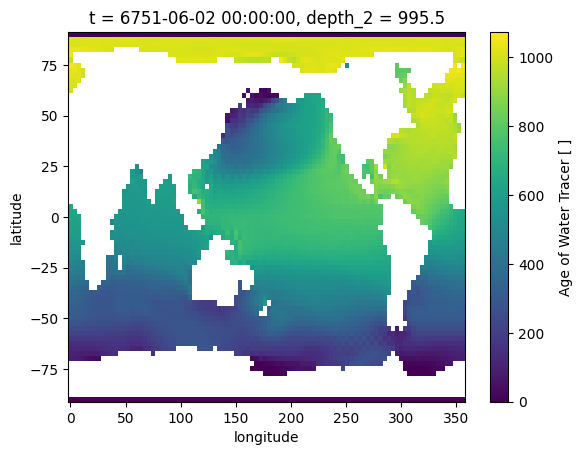

In [5]:
# Assume ds_list contains your datasets with computed AOU
# Get AOU ranges
aour_min = float('inf')
aour_max = float('-inf')

for i, ds in enumerate(ds_list):
    print(dscb_list[i])
    aour_min = float(ds['aOUR'].min())
    aour_max = float(ds['aOUR'].max())
    print(f"Min AOUR: {aour_min}, Max AOUR: {aour_max}")

print(f"Global AOUR range: {aour_min} to {aour_max}")
ds['aOUR']
age.isel(t=0, depth_2=12).plot()

In [178]:
ds_list[0]

<xarray.Dataset> Size: 13MB
Dimensions:                     (longitude: 96, latitude: 73, depth: 19, t: 1,
                                 depth_1: 1, depth_2: 20, unspecified: 1,
                                 longitude_1: 96, latitude_1: 72)
Coordinates:
  * longitude                   (longitude) float32 384B 0.0 3.75 ... 356.2
  * latitude                    (latitude) float32 292B -90.0 -87.5 ... 90.0
  * depth                       (depth) float32 76B 10.0 20.0 ... 4.885e+03
  * t                           (t) object 8B 6751-06-02 00:00:00
  * depth_1                     (depth_1) float32 4B 5.0
  * depth_2                     (depth_2) float32 80B 5.0 15.0 ... 5.193e+03
  * unspecified                 (unspecified) float32 4B -1.0
  * longitude_1                 (longitude_1) float32 384B 1.875 5.625 ... 358.1
  * latitude_1                  (latitude_1) float32 288B -88.75 ... 88.75
Data variables: (12/35)
    W_ym_dpth                   (t, depth, latitude, longitude) float32 533kB ...
    field645_ym_dpth            (t, depth_1, latitude, longitude) float32 28kB ...
    field646_ym_dpth            (t, depth_1, latitude, longitude) float32 28kB ...
    field647_ym_dpth            (t, depth_1, latitude, longitude) float32 28kB ...
    dSalinitydt_ym_dpth         (t, depth_1, latitude, longitude) float32 28kB ...
    field891_ym_dpth            (t, depth_1, latitude, longitude) float32 28kB ...
    ...                          ...
    PLE_ym_uo                   (t, unspecified, latitude, longitude) float32 28kB ...
    outflow_ym_uo               (t, unspecified, latitude, longitude) float32 28kB ...
    anomSaltFlux_ym_uo          (t, unspecified, latitude, longitude) float32 28kB ...
    O2_sat                      (t, depth_2, latitude, longitude) float64 1MB ...
    AOU                         (t, depth_2, latitude, longitude) float64 1MB ...
    aOUR                        (t, depth_2, latitude, longitude) float64 1MB ...
Attributes:
    history:  Tue Apr 16 23:32:12 2024: ncea -O xpvhao#pg000006751c1+.nc xpvh...
    NCO:      netCDF Operators version 4.9.2 (Homepage = http://nco.sf.net, C...

/var/folders/sq/wfj9lzcx6437thzlt85cgjwr0000gp/T/ipykernel_1569/1632154551.py:105: UserWarning: Adding colorbar to a different Figure <Figure size 2200x2800 with 21 Axes> than <Figure size 1400x1000 with 6 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(im, ax=axs1[:, 0:3], orientation='vertical',


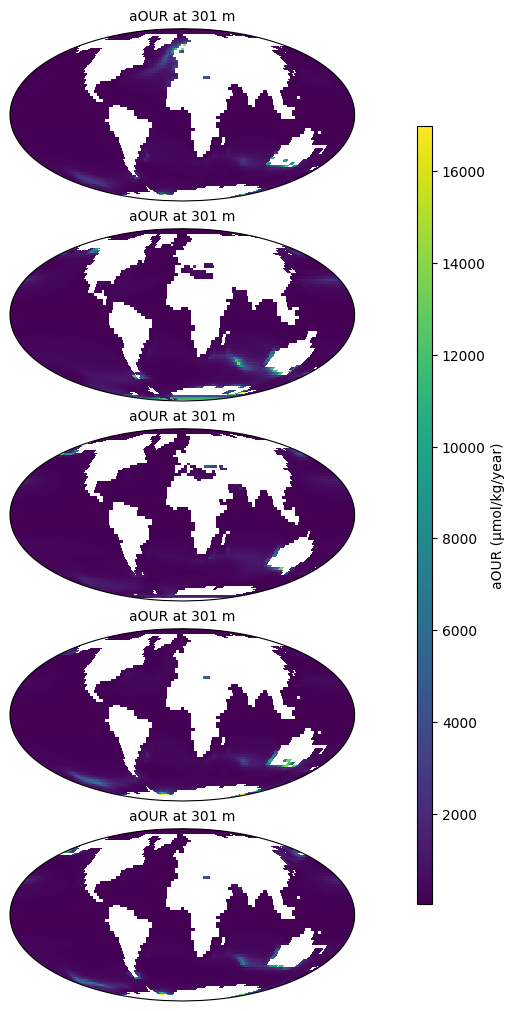

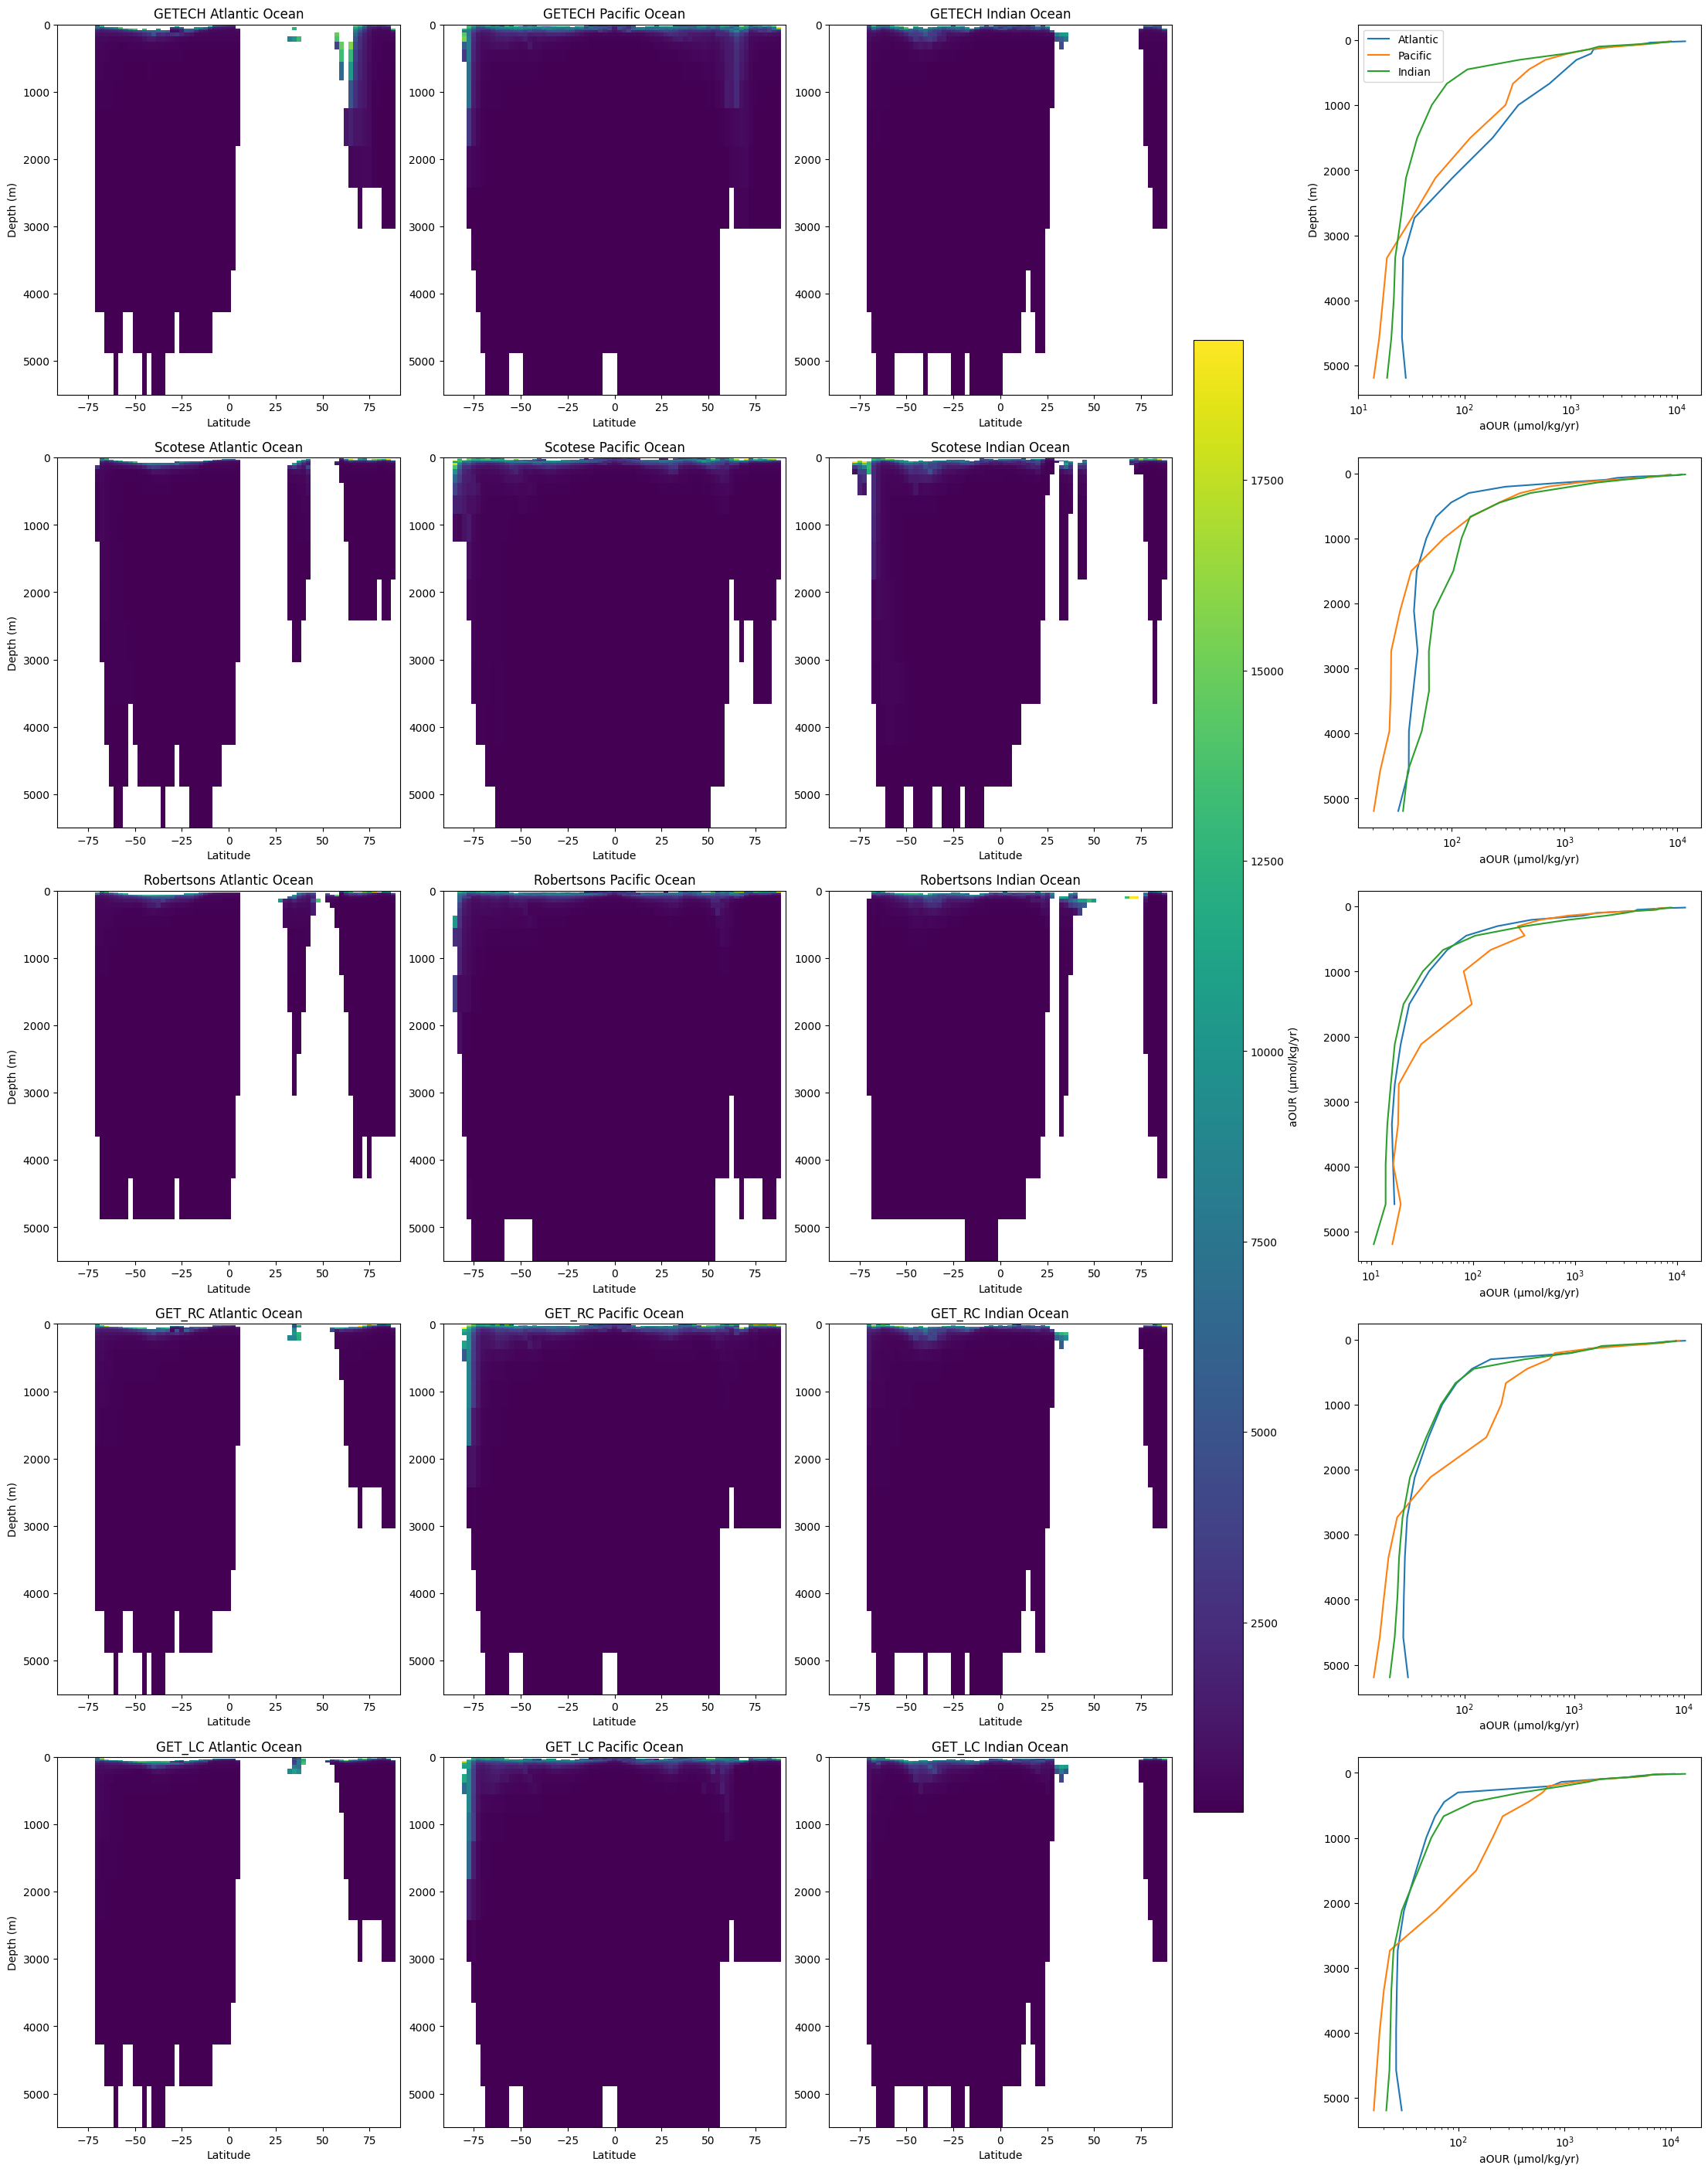

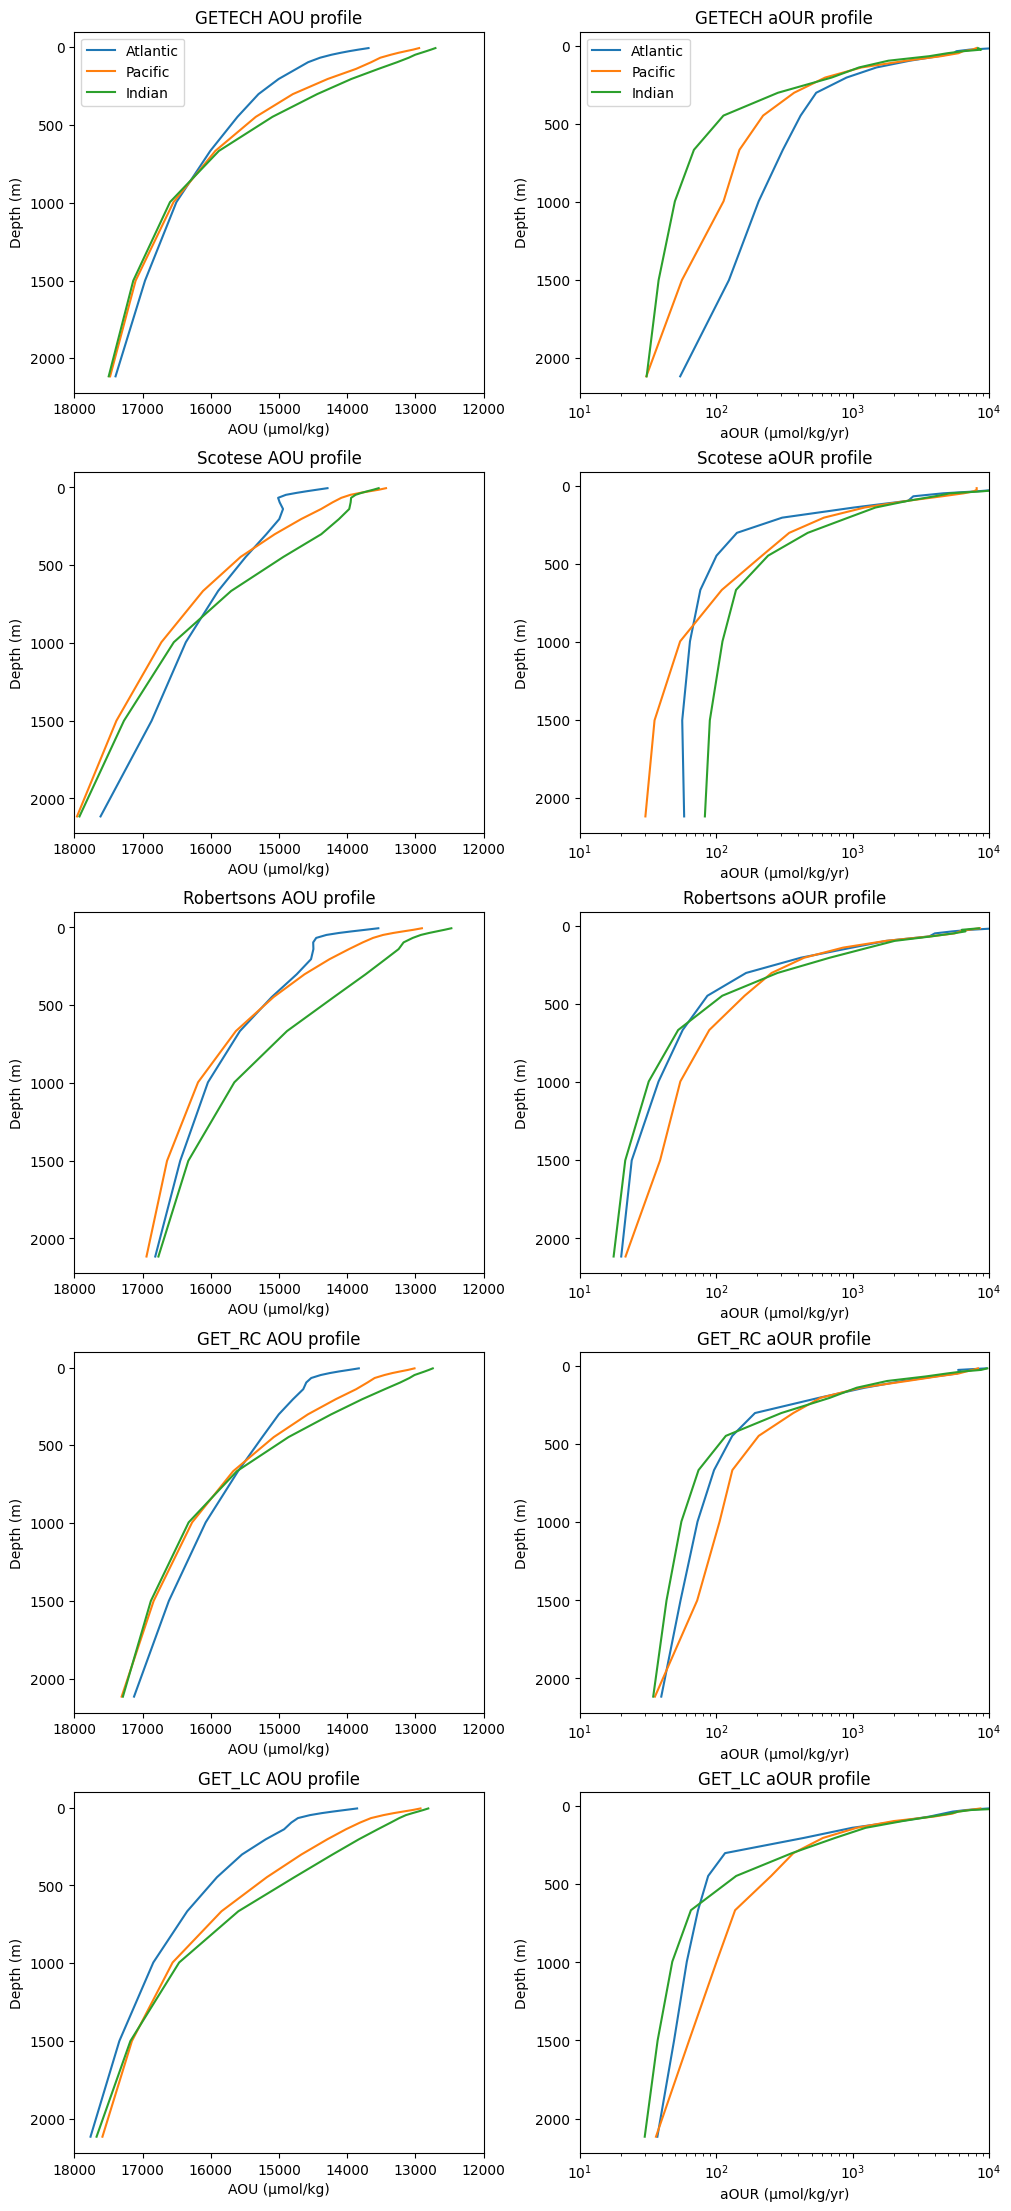

In [13]:
# ==============================================
# This is a copy of the following cell, to test.
# Test okay.
# ==============================================

# figure for global patterns at 301m
# loop over ds_list
# plots for vertical layers
rows, cols =5, 1
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(14,10), constrained_layout=True,
                        subplot_kw={'projection': ccrs.Mollweide()})
# fig1, axs1 = plt.subplots(5, 3, figsize=(18, 28), sharey=True)
# fig2, axs2 = plt.subplots(5, 3, figsize=(18, 28), sharey=True)

fig1, axs1 = plt.subplots(
    nrows=5, ncols=4,
    figsize=(22, 28),
    constrained_layout=True
)

fig2, axs2 = plt.subplots(nrows=5, ncols=2, figsize=(10, 22), constrained_layout=True)

# layer plot
for i, ds in enumerate(ds_list):

    aour = ds['aOUR']
    aour_masked = aour.where(aour > 1e-2)
    
    ax = axs[i]
    im = ax.pcolormesh(
        lon, lat, aour_masked.isel(t=0, depth_2=9), shading='auto', cmap='viridis',
        # norm=LogNorm(vmin=1e-2, vmax=3e10), 
        transform=ccrs.PlateCarree()
        )
    ax.set_title(f"aOUR at {int(depth[9].values)} m", fontsize=10)

fig.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical', label='aOUR (µmol/kg/year)',
                shrink=0.8, aspect=50)
# fig.suptitle(dscb_list[i], fontsize=14)

colors = {"Atlantic": "tab:blue", "Pacific": "tab:orange", "Indian": "tab:green"}


# basin masks
basins = {
    "Atlantic": ((lon >= -100) & (lon <= 20)),
    "Pacific":  ((lon >= 120) | (lon <= -70)),
    "Indian":   ((lon >= 20) & (lon <= 120)),
}

# depth profile plot
for i in range(rows):   # 5 simulations
    # get data
    aou = ds_list[i]['AOU']
    aour = ds_list[i]['aOUR']
    aour_masked = aour.where(aour > 1e-2)

    # basin masks
    basins = {
        "Atlantic": ((lon >= -100) & (lon <= 20)),
        "Pacific":  ((lon >= 120) | (lon <= -70)),
        "Indian":   ((lon >= 20) & (lon <= 120)),
    }

    # --- loop over 3 basins for zonal mean ---
    for j, (name, mask) in enumerate(basins.items()):
        ax = axs1[i, j]

        aour_basin = aour_masked.where(mask, drop=True)
        aour_basin_top = aour_basin.isel(depth_2=slice(0, 20))   # top 10 layers
        aour_zonal_mean = aour_basin_top.mean(dim="longitude", skipna=True)

        im = aour_zonal_mean.plot(
            ax=ax, y="depth_2", yincrease=False, cmap="viridis",
            # norm=LogNorm(vmin=1e-2, vmax=5e3),
            add_colorbar=False
        )

        ax.set_title(f"{dscb_list[i]} {name} Ocean")
        ax.set_xlabel("Latitude")
        if j == 0:
            ax.set_ylabel("Depth (m)")
        else:
            ax.set_ylabel("")

        # --- vertical profile (depth mean vs. depth) in the 4th col ---
        profile = aour_zonal_mean.mean(dim="latitude", skipna=True)  # 1D over depth
        ax_prof = axs1[i, 3]
        ax_prof.plot(profile.squeeze().values,
                     profile['depth_2'].values,
                     label=name, color=colors[name])

    # formatting the profile axis (col 3)
    ax_prof.set_xscale("log")
    ax_prof.invert_yaxis()
    ax_prof.set_xlabel("aOUR (µmol/kg/yr)")
    if i == 0:
        ax_prof.legend()
    # label y only once per row for clarity
    if i == 0:
        ax_prof.set_ylabel("Depth (m)")
    else:
        ax_prof.set_ylabel("")
# Add a shared colorbar for the zonal mean maps
cbar = fig.colorbar(im, ax=axs1[:, 0:3], orientation='vertical',
                    shrink=0.7, aspect=30, pad=0.02,
                    label="aOUR (µmol/kg/yr)")

for i in range(rows):   # 5 simulations
    # aou and aour profile
    ax_aou = axs2[i, 0]
    ax_aour = axs2[i, 1]
    for name, mask in basins.items():
        aou = ds_list[i]['AOU'].where(mask, drop=True).isel(depth_2=slice(0, 15))
        prof_aou = aou.mean(dim=["latitude","longitude"], skipna=True).squeeze()
        aour = (ds_list[i]['aOUR']).where(mask, drop=True).isel(depth_2=slice(0, 15))
        prof_aour = aour.mean(dim=["latitude","longitude"], skipna=True).squeeze()
        ax_aou.plot(prof_aou.values, prof_aou['depth_2'].values, 
                    label=name, color=colors[name])
        ax_aour.plot(prof_aour.values, prof_aour['depth_2'].values,
                     label=name, color=colors[name])
    ax_aou.invert_yaxis()
    
    ax_aou.set_xlim(12000, 18000)
    ax_aou.invert_xaxis()
    ax_aou.set_xlabel("AOU (µmol/kg)")
    ax_aou.set_ylabel("Depth (m)")
    ax_aou.set_title(f"{dscb_list[i]} AOU profile")
    if i==0: ax_aou.legend()

    ax_aour.set_xlim(10, 10000)
    ax_aour.invert_yaxis()
    ax_aour.set_xscale("log")
    ax_aour.set_xlabel("aOUR (µmol/kg/yr)")
    ax_aour.set_ylabel("Depth (m)")
    ax_aour.set_title(f"{dscb_list[i]} aOUR profile")
    if i == 0: ax_aour.legend()

plt.show()

    # fig.colorbar(im, ax=axs.ravel().tolist(), label="aOUR (µmol/kg)", orientation='vertical')

    # fig1.suptitle(f"Zonal Mean aOUR by Ocean Basin in {dscb_list[i]}", fontsize=14)

    # export figure
    # dir_outpath1 = os.path.join(dir_out, f"aOUR_zonal_mean_ocean_basins_{dscb_list[i]}.png")
    # fig1.savefig(dir_outpath1, dpi=300)

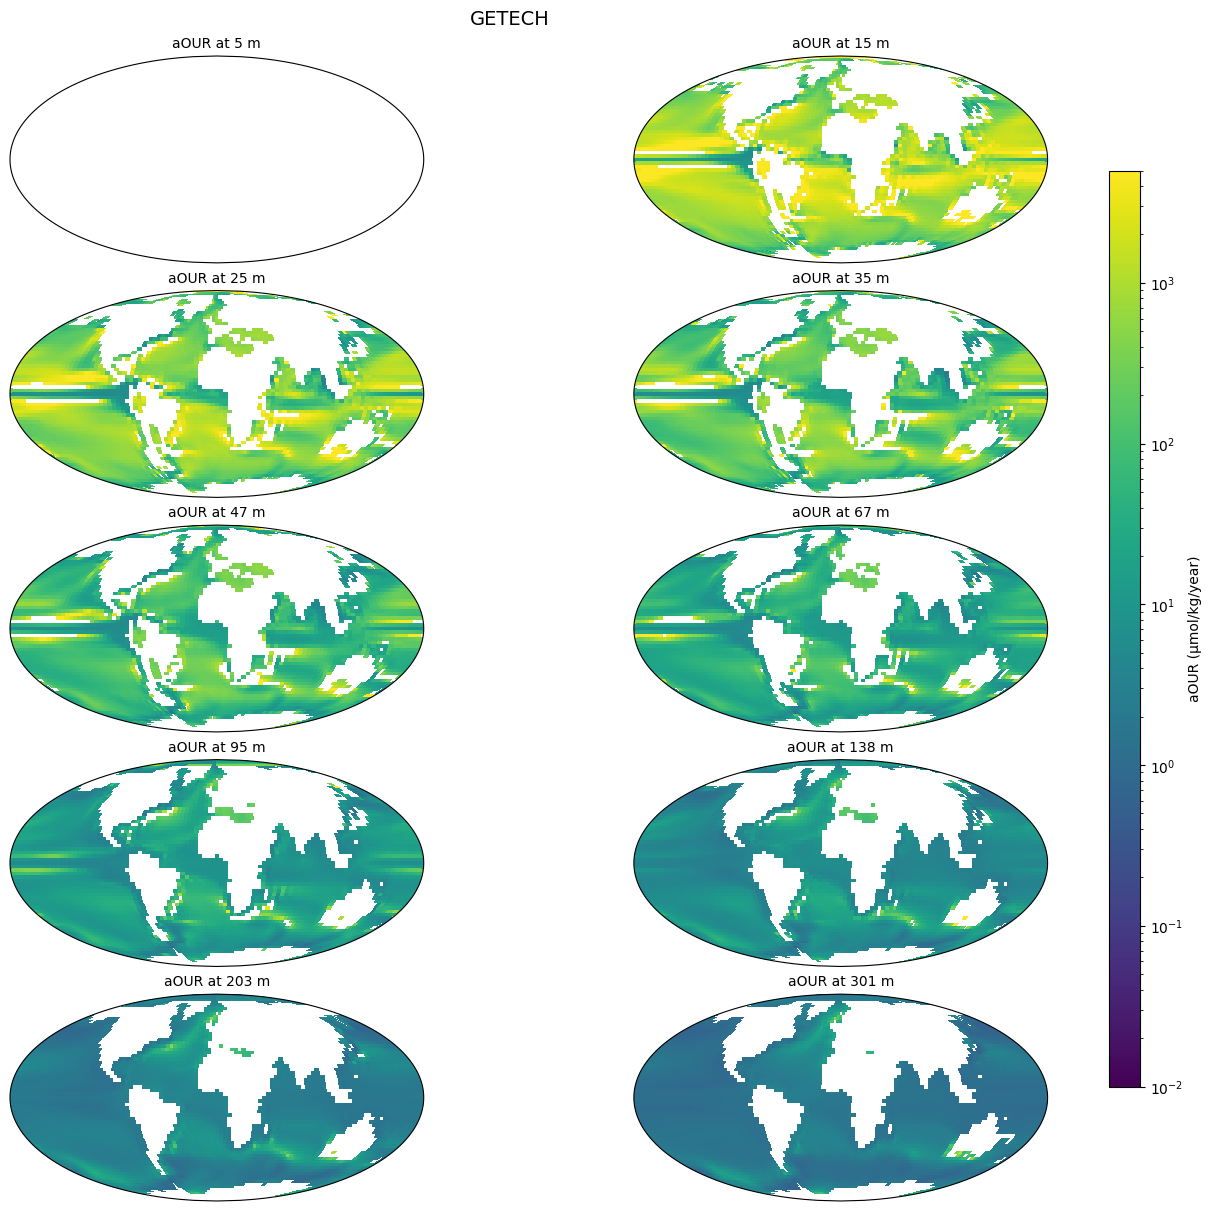

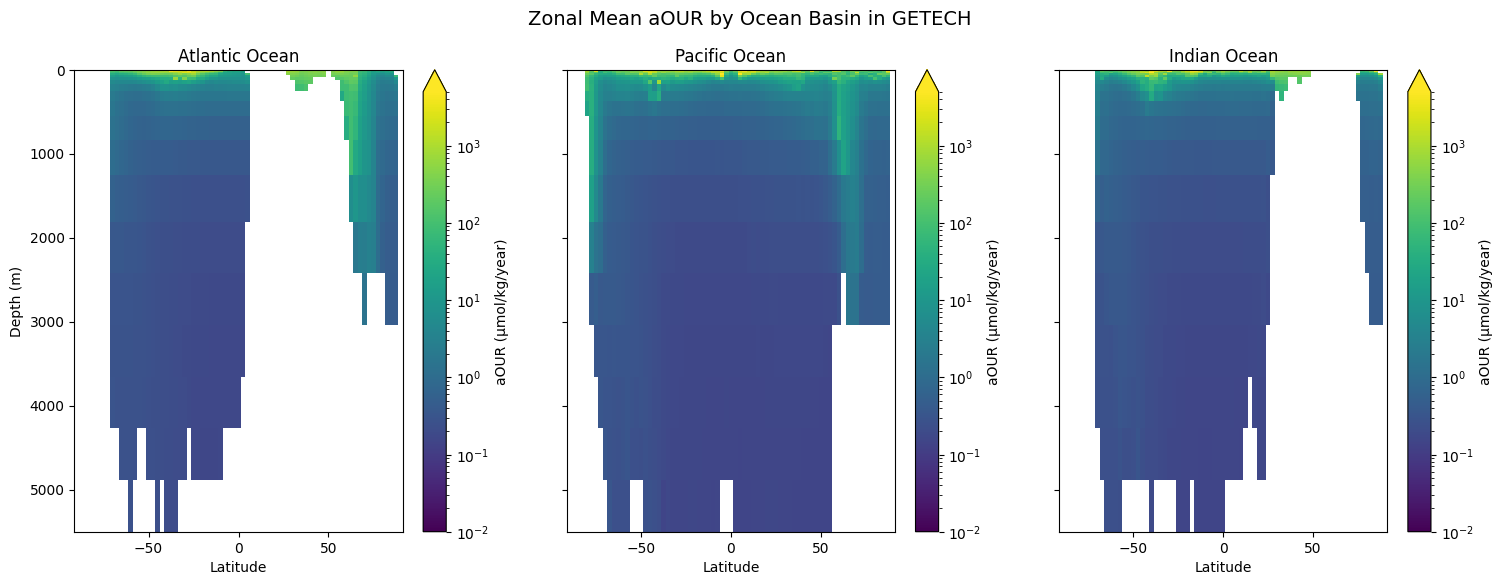

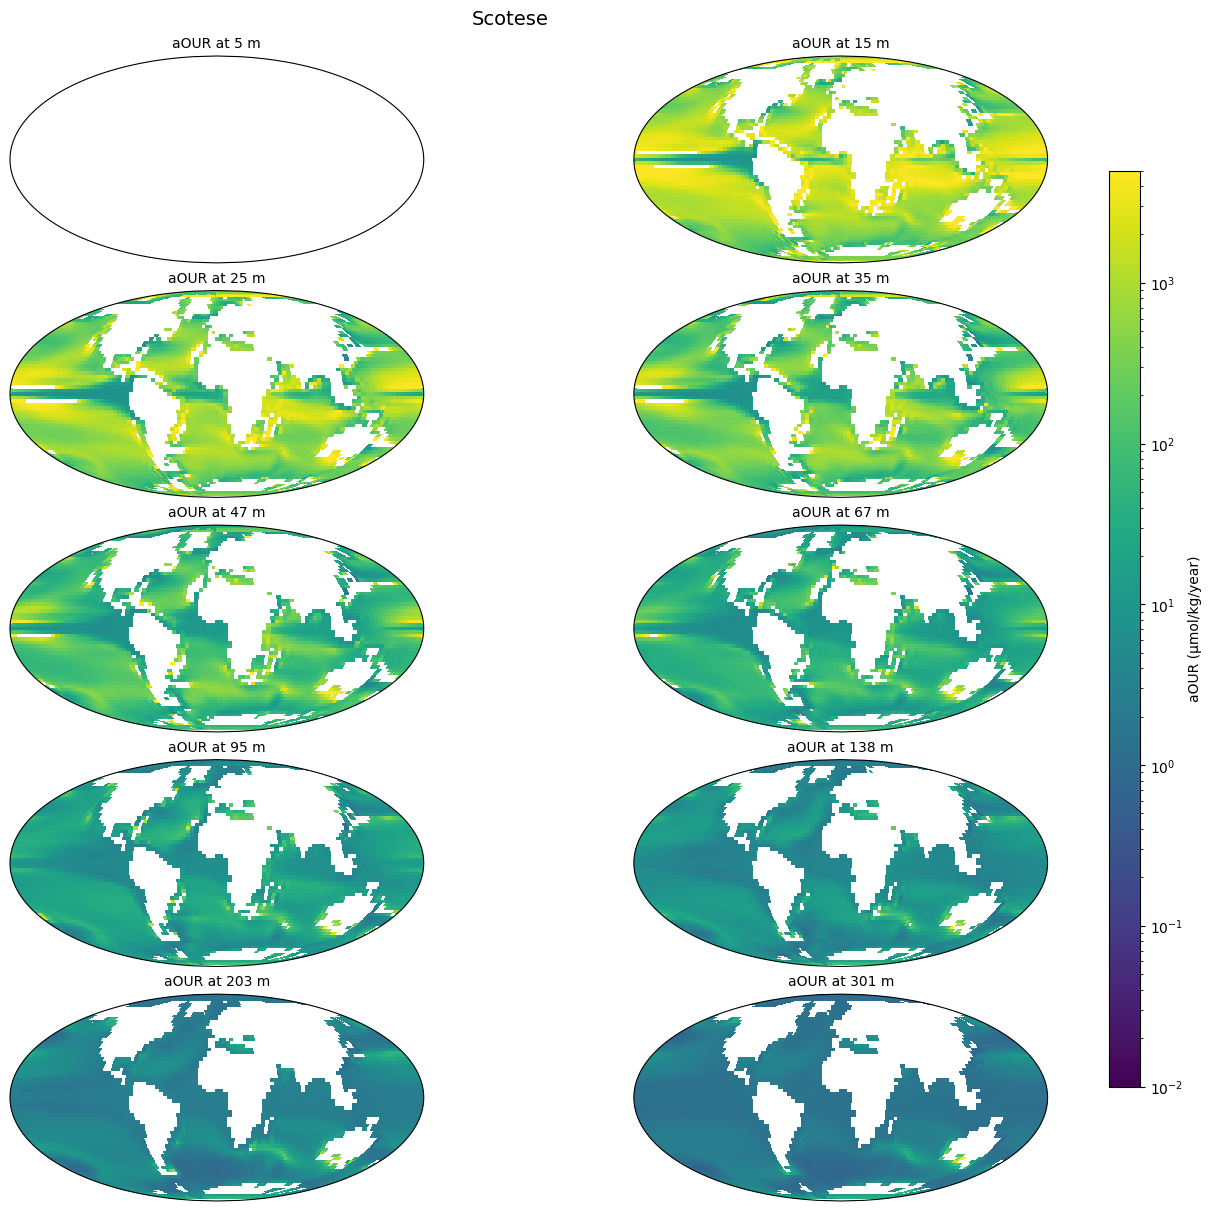

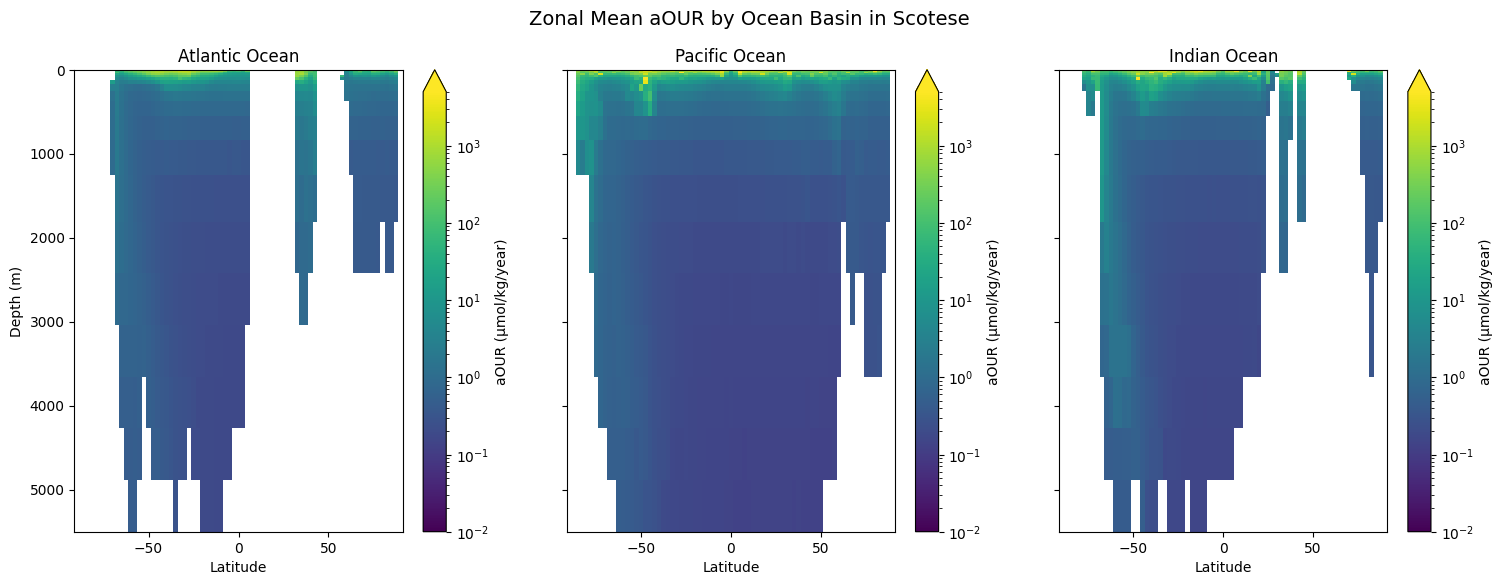

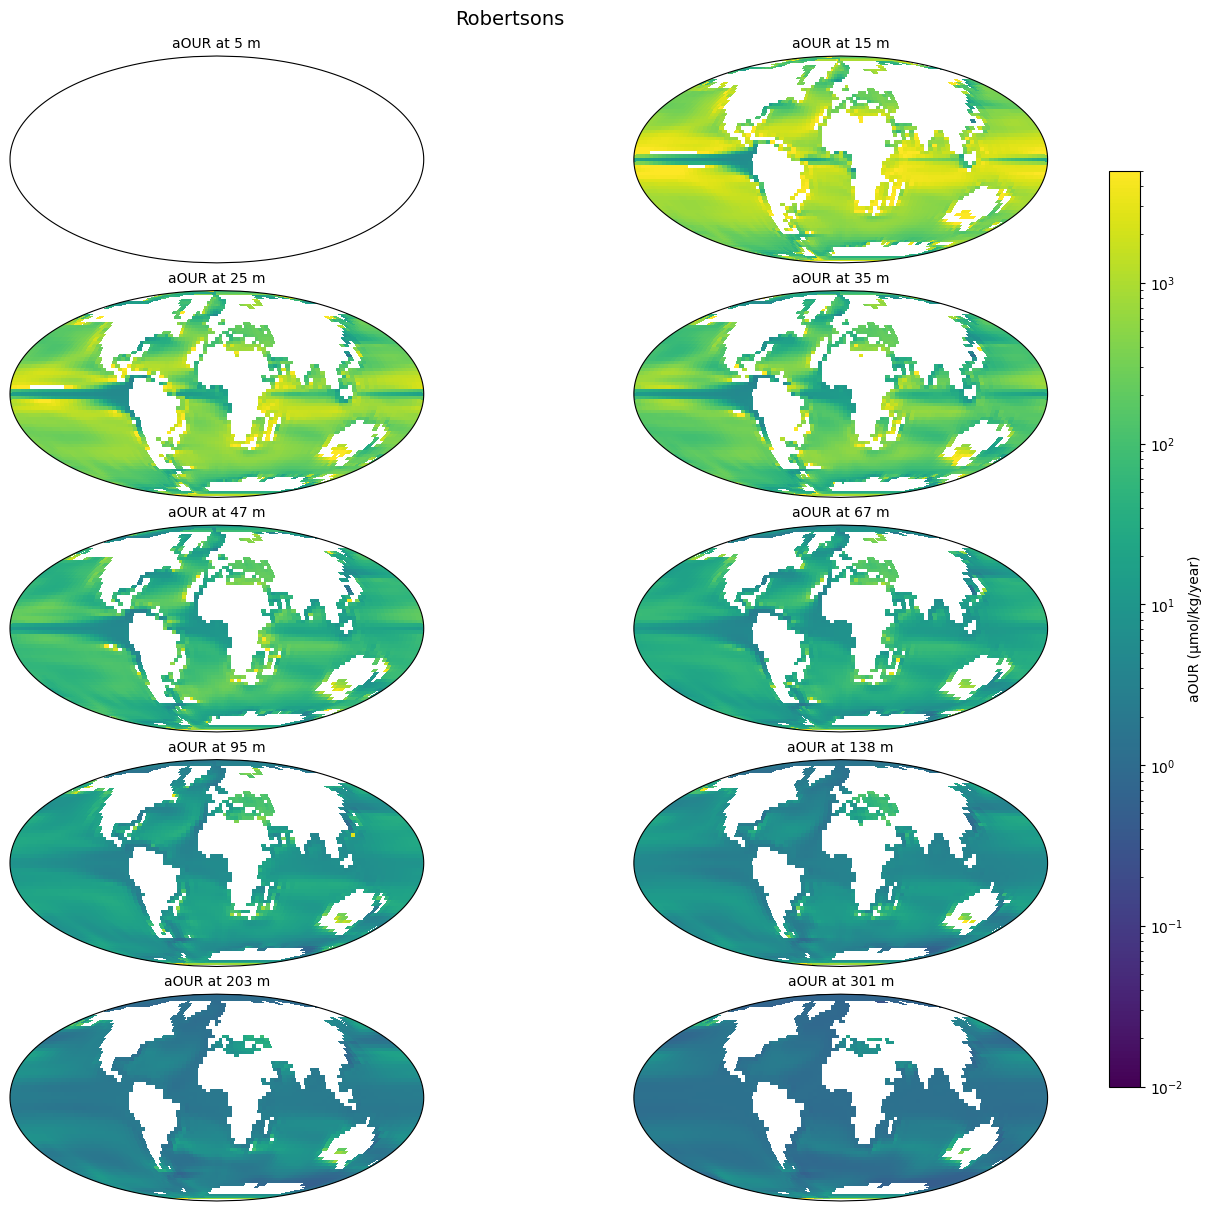

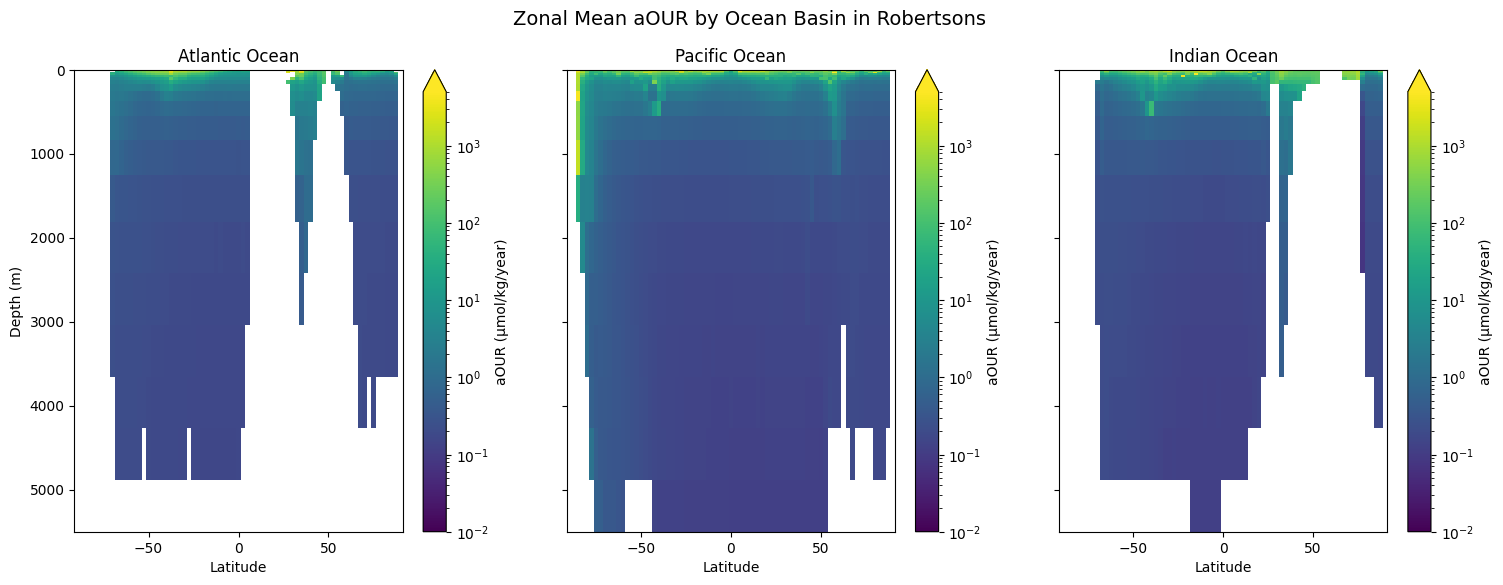

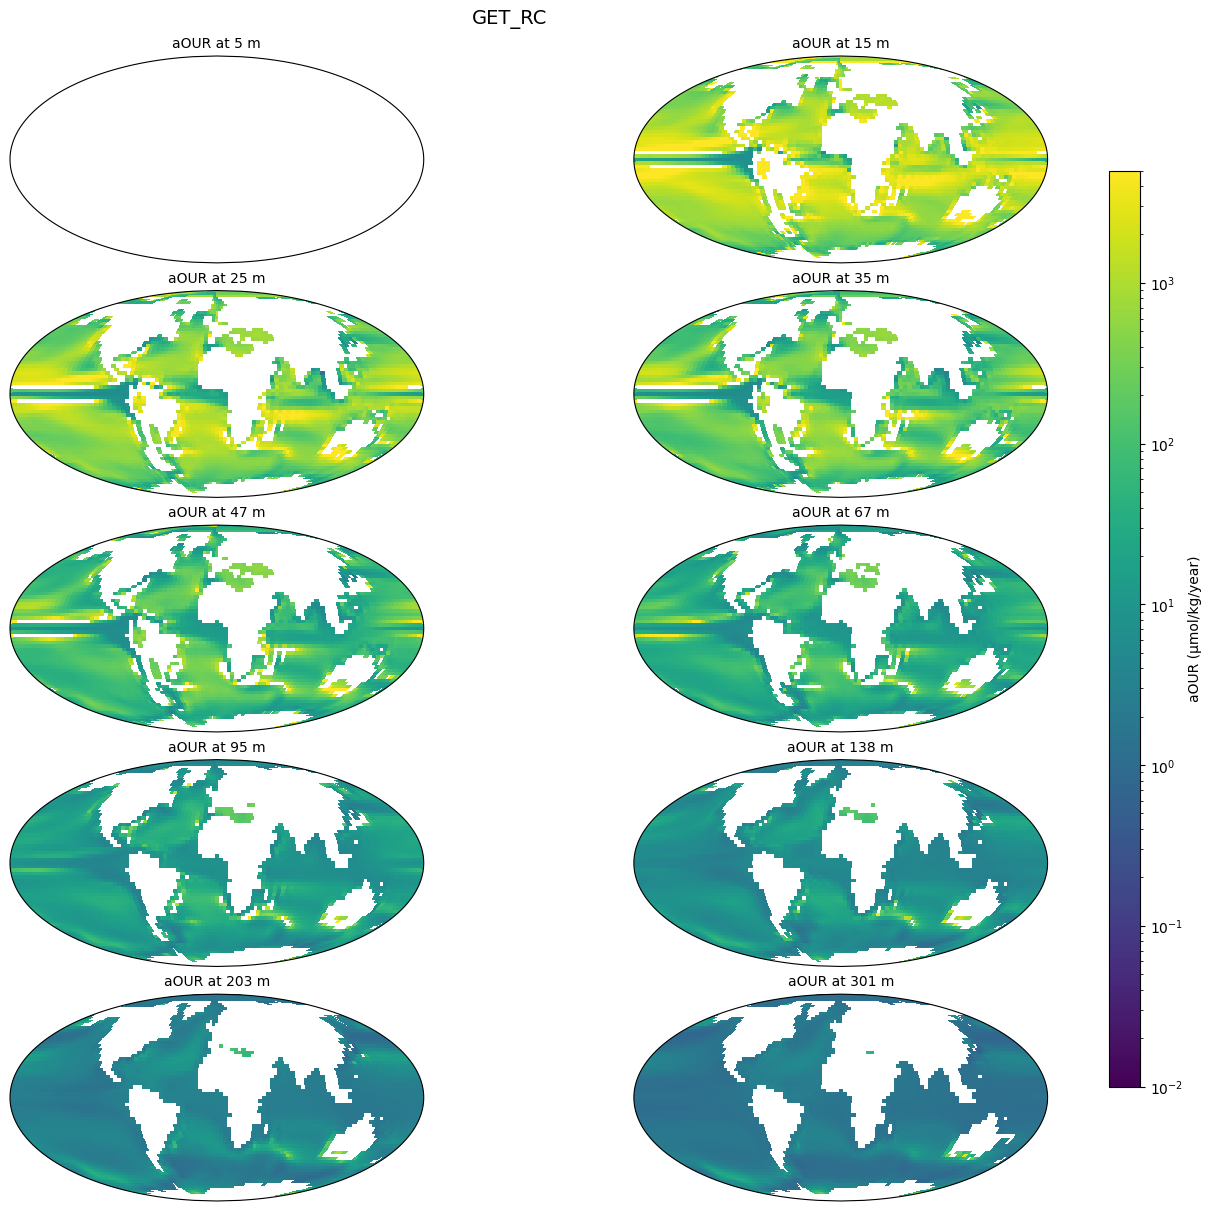

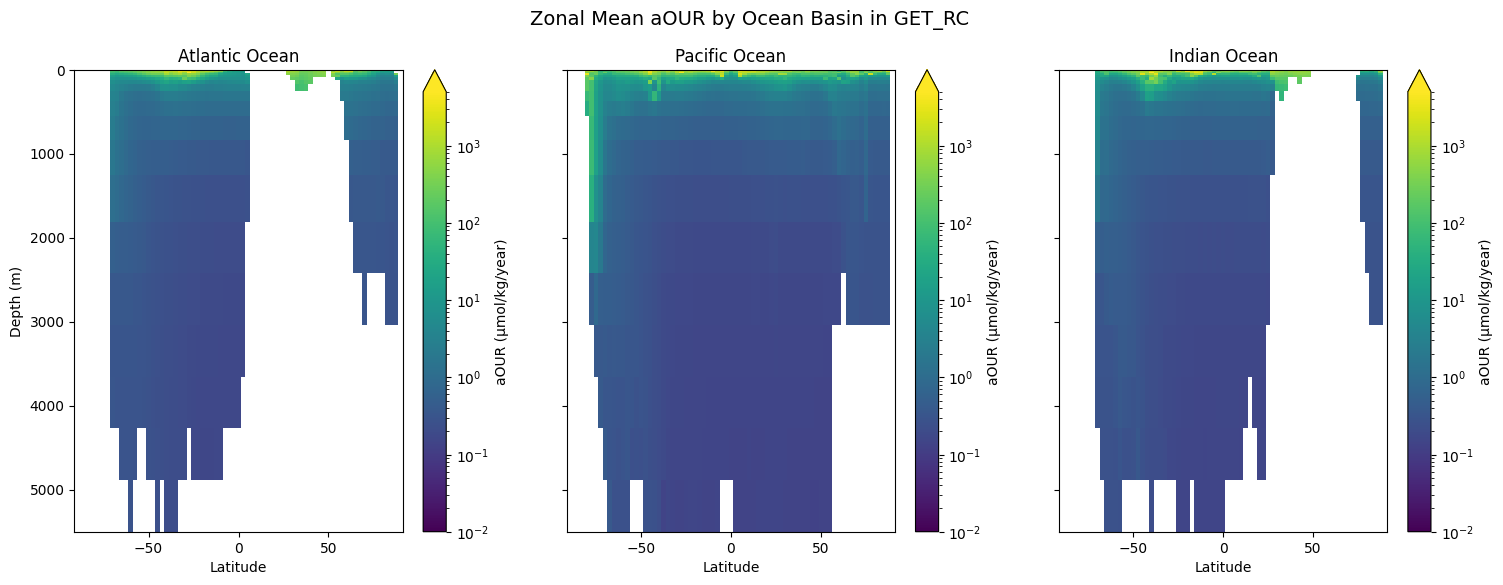

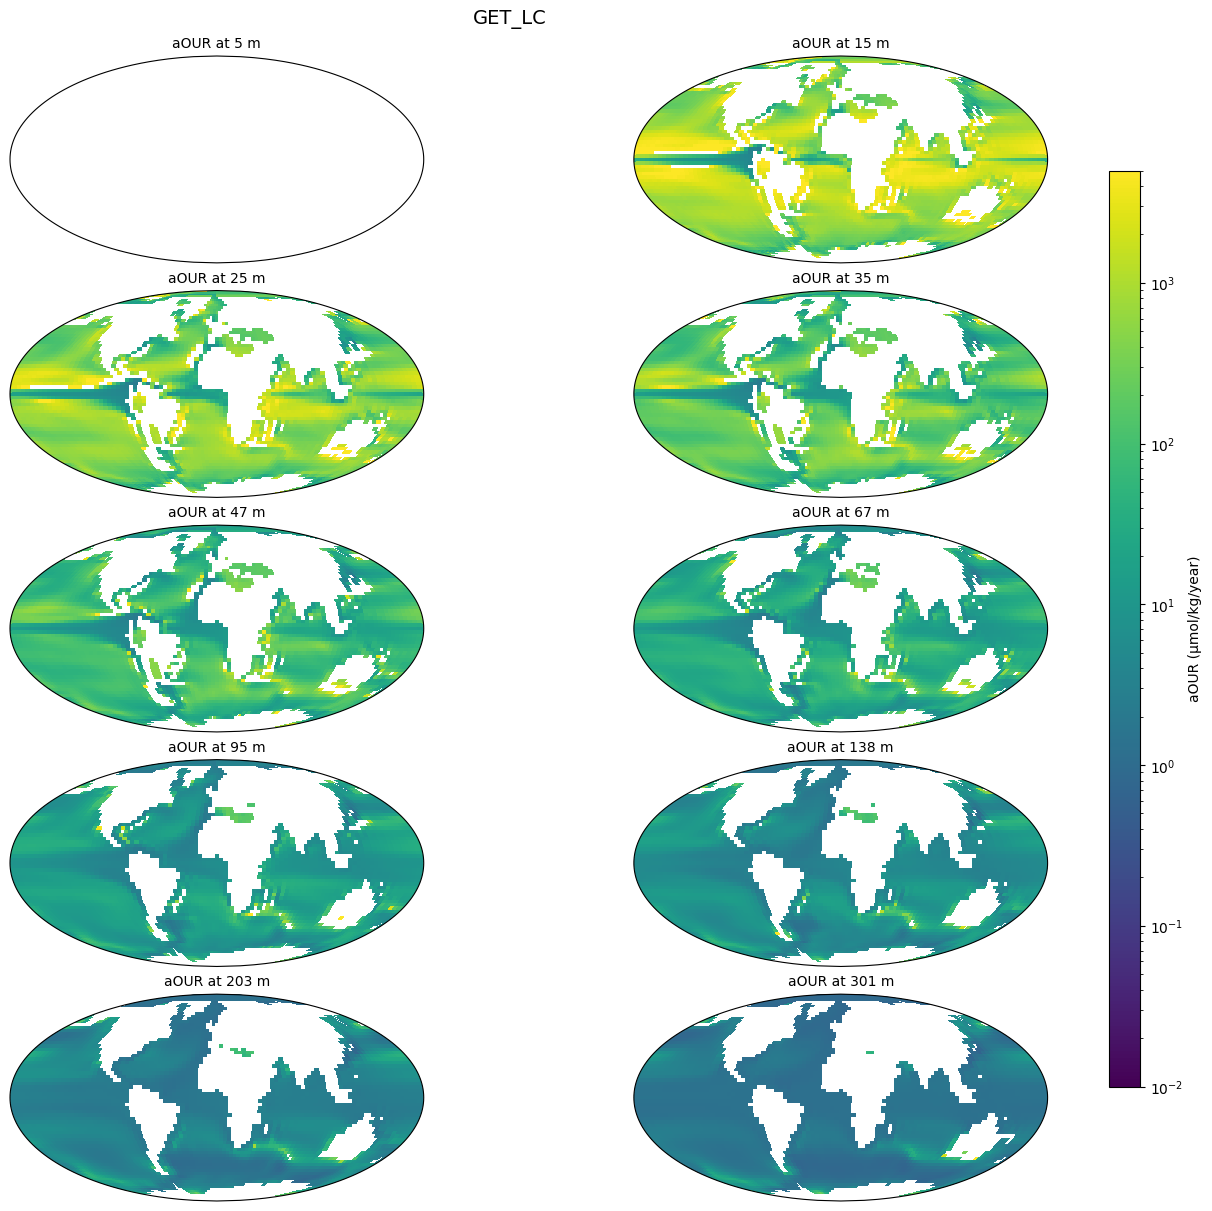

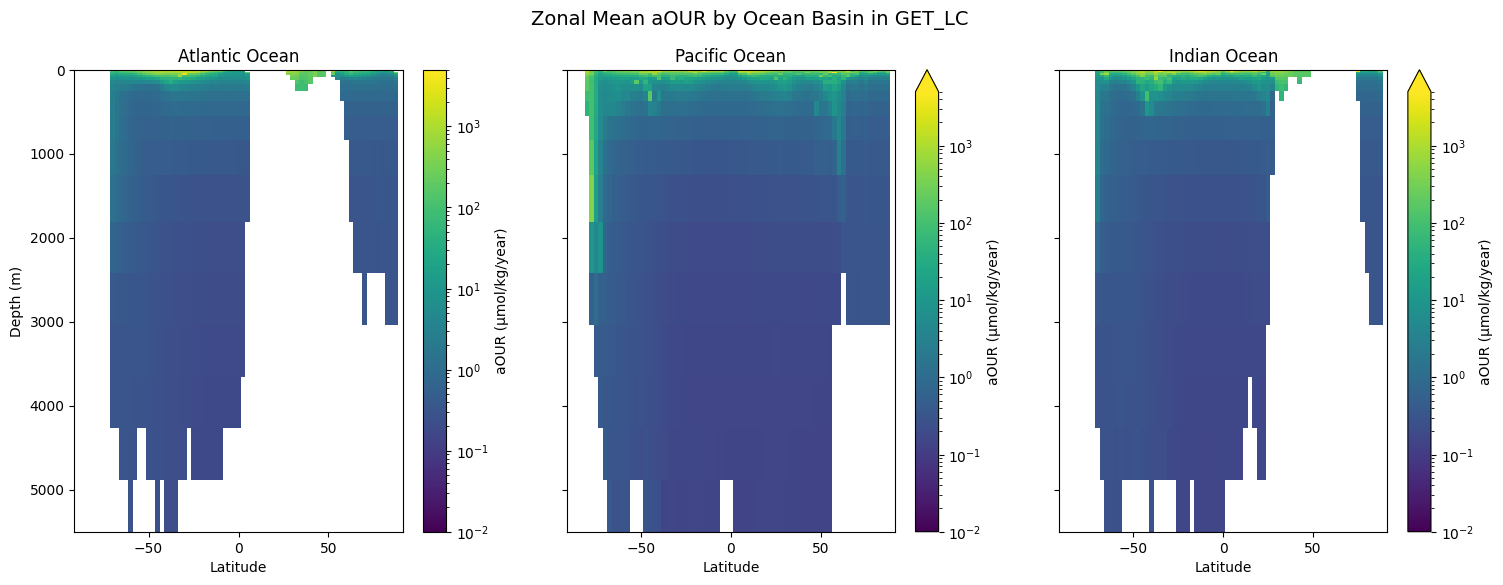

In [33]:
# loop over ds_list
for i, ds in enumerate(ds_list):

    aour = ds['aOUR']
    aour_masked = aour.where(aour > 1e-2)
    # plots for vertical layers
    rows, cols =5, 2
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(14,12), constrained_layout=True,
                            subplot_kw={'projection': ccrs.Mollweide()})
    for d, ax in zip(range(rows * cols), axs.ravel()):
        im = ax.pcolormesh(
            lon, lat, aour_masked.isel(t=0, depth_2=d), shading='auto', cmap='viridis',
            norm=LogNorm(vmin=1e-2, vmax=5e3), transform=ccrs.PlateCarree()
            )
        ax.set_title(f"aOUR at {int(depth[d].values)} m", fontsize=10)

    fig.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical', label='aOUR (µmol/kg/year)',
                    shrink=0.8, aspect=30)
    fig.suptitle(dscb_list[i], fontsize=14)

    # export figure
    dir_outpath = os.path.join(dir_out, f"aOUR_depth_layers_{dscb_list[i]}.png")
    fig.savefig(dir_outpath, dpi=300,)

    # plots for zonal means
    # Ocean basin masks
    basins = {
        "Atlantic": ((lon >= -100) & (lon <= 20)),
        "Pacific": ((lon >= 120) | (lon <= -70)),
        "Indian": ((lon >= 20) & (lon <= 120)),
    }

    fig1, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    # Zonal mean plots
    for j, (name, mask) in enumerate(basins.items()):
        ax = axs[j]
        aour_basin = aour_masked.where(mask, drop=True)
        zonal_mean = aour_basin.mean(dim="longitude", skipna=True)

        im = zonal_mean.plot(
            ax=ax, y="depth_2", yincrease=False, cmap="viridis", 
            norm=LogNorm(vmin=1e-2, vmax=5e3), cbar_kwargs={"label": "aOUR (µmol/kg/year)"}
            )
        ax.set_title(f"{name} Ocean")
        ax.set_xlabel("Latitude")
        # for first column only set up y label
        if j == 0:
            ax.set_ylabel("Depth (m)")
        else:
            ax.set_ylabel("")

    # fig.colorbar(im, ax=axs.ravel().tolist(), label="aOUR (µmol/kg)", orientation='vertical')

    fig1.suptitle(f"Zonal Mean aOUR by Ocean Basin in {dscb_list[i]}", fontsize=14)

    # export figure
    dir_outpath1 = os.path.join(dir_out, f"aOUR_zonal_mean_ocean_basins_{dscb_list[i]}.png")
    fig1.savefig(dir_outpath1, dpi=300)

### test 3d plot here

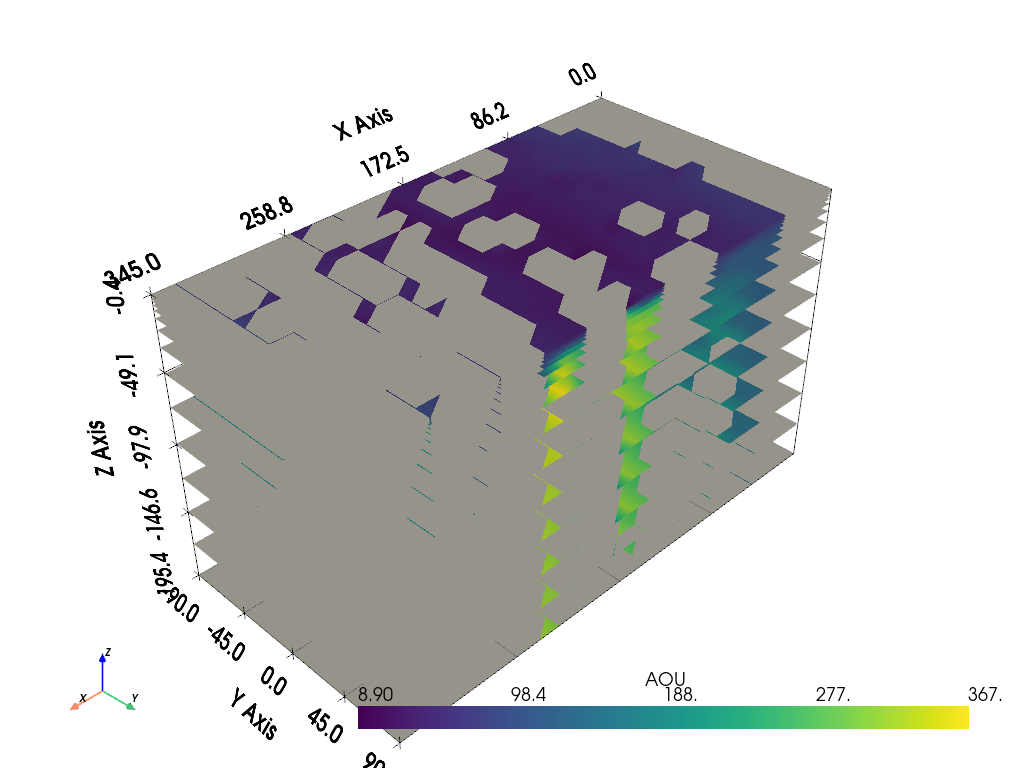

In [13]:
# test 3d volume here
import pyvista as pv
pv.set_jupyter_backend('static')

# get essential variables
ds = ds_list[0]

# add to dataset
aou = ds['AOU'].isel(t=0)

# Get coordinate arrays
lon = ds['longitude'].values
lat = ds['latitude'].values
depth = ds['depth_2'].values

# Downsample to reduce size
aou = aou.isel(longitude=slice(None, None, 4), latitude=slice(None, None, 4))
lon = lon[::4]
lat = lat[::4]

# Meshgrid in lon-lat plane
lon2d, lat2d = np.meshgrid(lon, lat, indexing='ij')

# Create a uniform grid for each depth slab
plotter = pv.Plotter()
for k in range(len(depth) - 1):
    z_top = -depth[k]
    z_bot = -depth[k+1]
    z_mid = (z_top + z_bot) / 2

    # AOU at layer k (constant over slab thickness)
    aou_layer = aou.isel(depth_2=k).values

    # Expand to 3D by stacking top and bottom
    nx, ny = aou_layer.shape
    x = lon2d.flatten()
    y = lat2d.flatten()
    z = np.full_like(x, z_mid)

    points = np.column_stack((x, y, z*0.04))
    grid = pv.StructuredGrid()
    grid.points = points
    grid.dimensions = [nx, ny, 1]
    grid["AOU"] = aou_layer.flatten()

    surf = grid.cast_to_unstructured_grid().extract_surface()
    plotter.add_mesh(surf, scalars="AOU", cmap="viridis", show_edges=False, opacity=1)

# Final display
plotter.add_axes()
plotter.show_grid()
plotter.show()